

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_image_count =  int(qbz95.utils.get_notebook_name().split('.')[0].split('_')[3])

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*10/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120},
        'custom':{'dropout':0.2, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':120}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2022-08-09 09:28:07,819: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json


### 下载数据

开始下载数据。

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [6]:
_, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(20000, 32, 32, 3) (20000,)
(10000, 32, 32, 3) (10000,)


In [7]:
Counter(train_labels)

Counter({7: 1993,
         8: 2045,
         0: 1973,
         6: 1940,
         1: 1979,
         5: 2033,
         2: 2009,
         4: 1944,
         3: 2041,
         9: 2043})



### 查看数据

下面看一看实际的数据是啥样的。

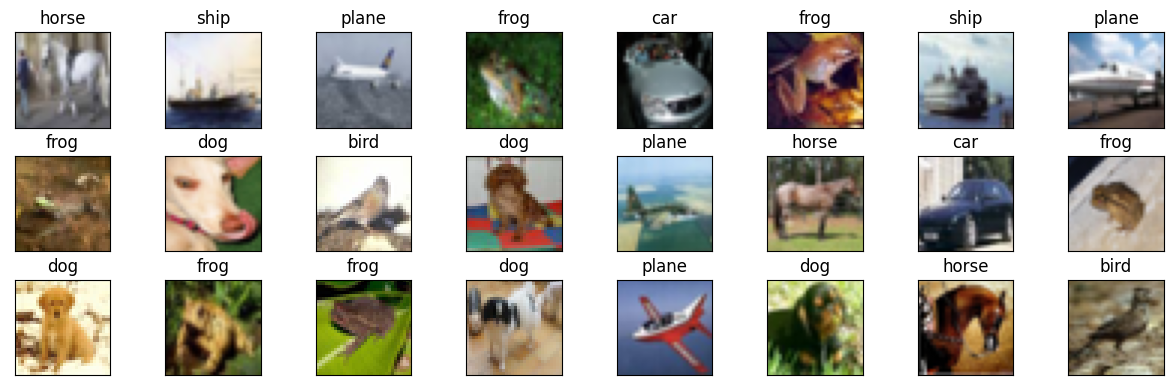

In [8]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

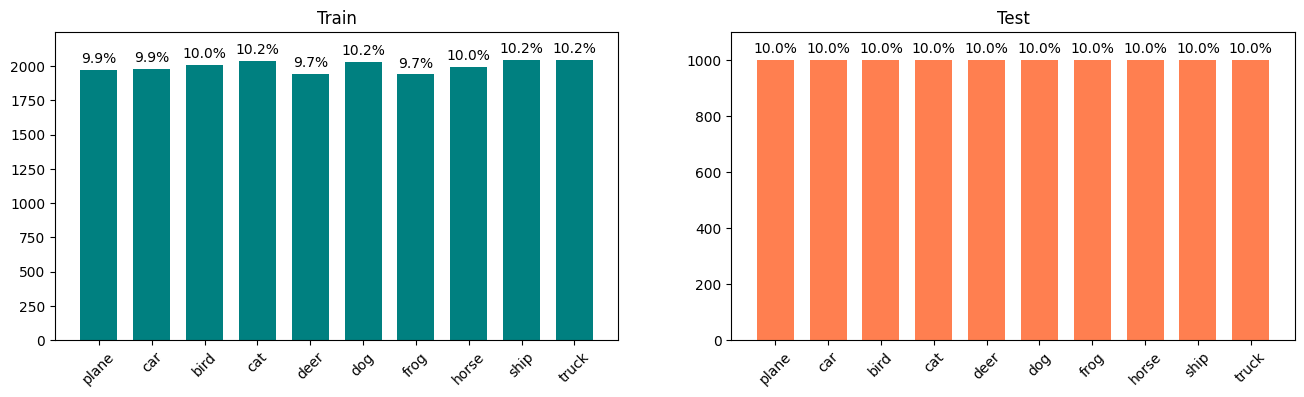

In [9]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [10]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [11]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [12]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

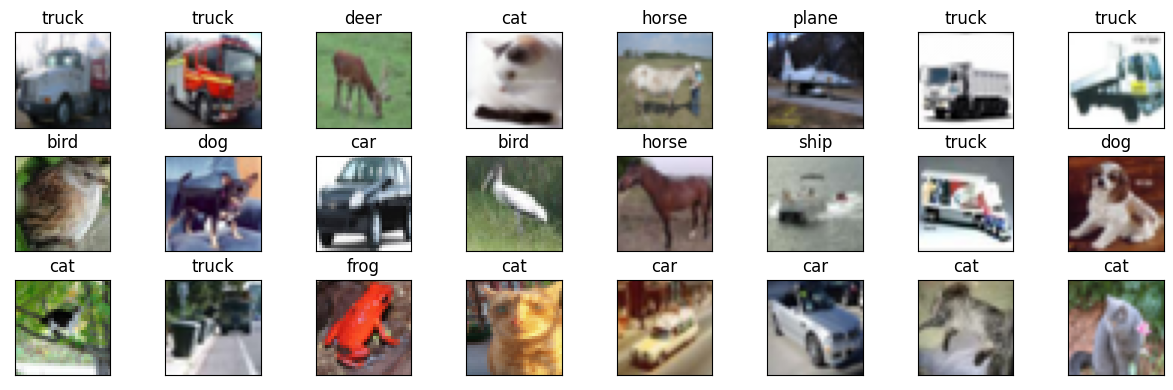

In [13]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [14]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

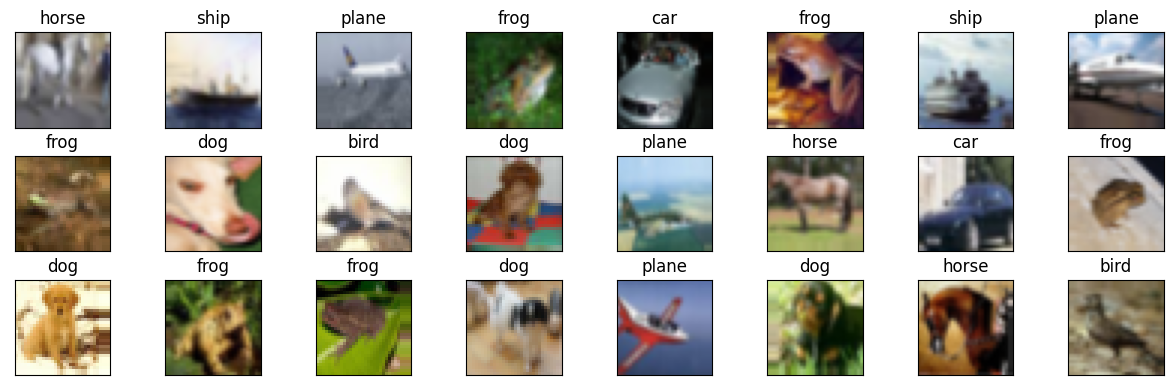

In [15]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

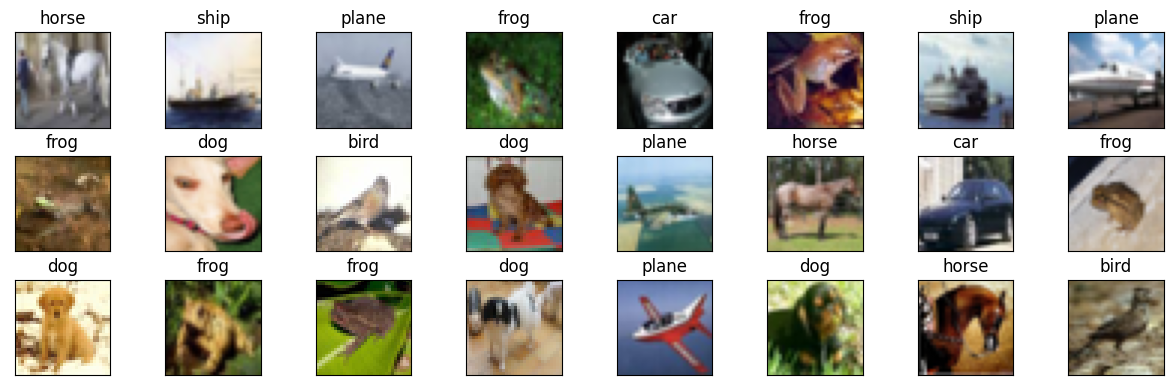

In [16]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [17]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [18]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


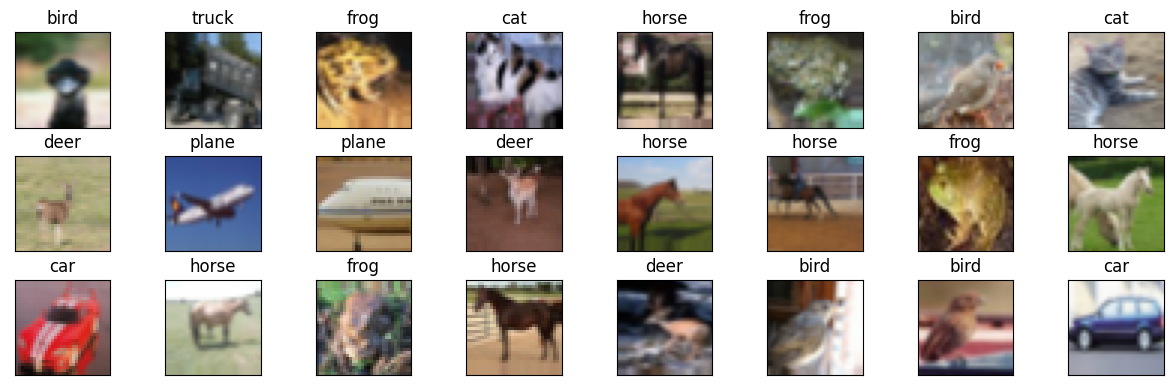

In [19]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2022-08-09 09:28:24,123: INFO: model_params.mlp1.dropout=0.1
2022-08-09 09:28:24,124: INFO: model_params.mlp1.layer_count=1
2022-08-09 09:28:24,125: INFO: model_params.mlp1.units=128
2022-08-09 09:28:24,165: INFO: learning_rate=0.001
2022-08-09 09:28:24,165: INFO: model_params.mlp1.clip_value=None
2022-08-09 09:28:24,174: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
___________________________________________________________

2022-08-09 09:28:24,189: INFO: model_params.mlp1.epochs=120
2022-08-09 09:28:24,189: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1, monitor=val_accuracy)
2022-08-09 09:28:24,190: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 09:28:24,191: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 09:28:24,192: INFO: use LearningRateScheduler()
2022-08-09 09:28:24,192: INFO: steps_per_epoch=625
2022-08-09 09:28:24,193: INFO: start training
2022-08-09 09:28:24,194: INFO: use_class_weight=False


Epoch 1/120
620/625 [============================>.] - ETA: 0s - loss: 2.0466 - accuracy: 0.2423INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


2022-08-09 09:28:28,187: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 4s 5ms/step - loss: 2.0456 - accuracy: 0.2423 - val_loss: 1.8883 - val_accuracy: 0.3159 - lr: 0.0010
Epoch 2/120
614/625 [============================>.] - ETA: 0s - loss: 1.9071 - accuracy: 0.3007INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


2022-08-09 09:28:30,938: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.9060 - accuracy: 0.3009 - val_loss: 1.8263 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 3/120
617/625 [============================>.] - ETA: 0s - loss: 1.8592 - accuracy: 0.3235INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


2022-08-09 09:28:33,661: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.8590 - accuracy: 0.3239 - val_loss: 1.8050 - val_accuracy: 0.3432 - lr: 0.0010
Epoch 4/120
619/625 [============================>.] - ETA: 0s - loss: 1.8331 - accuracy: 0.3341INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


2022-08-09 09:28:36,395: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.8329 - accuracy: 0.3341 - val_loss: 1.7923 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 5/120
625/625 [==============================] - ETA: 0s - loss: 1.8024 - accuracy: 0.3419INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


2022-08-09 09:28:39,311: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.8024 - accuracy: 0.3419 - val_loss: 1.7458 - val_accuracy: 0.3692 - lr: 0.0010
Epoch 6/120
625/625 [==============================] - 2s 3ms/step - loss: 1.7952 - accuracy: 0.3463 - val_loss: 1.7771 - val_accuracy: 0.3561 - lr: 0.0010
Epoch 7/120
625/625 [==============================] - 2s 3ms/step - loss: 1.7841 - accuracy: 0.3523 - val_loss: 1.7443 - val_accuracy: 0.3683 - lr: 0.0010
Epoch 8/120
625/625 [==============================] - 2s 3ms/step - loss: 1.7666 - accuracy: 0.3566 - val_loss: 1.7612 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 9/120
621/625 [============================>.] - ETA: 0s - loss: 1.7619 - accuracy: 0.3587INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


2022-08-09 09:28:48,218: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.7619 - accuracy: 0.3587 - val_loss: 1.7177 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 10/120
625/625 [==============================] - 2s 3ms/step - loss: 1.7549 - accuracy: 0.3635 - val_loss: 1.7509 - val_accuracy: 0.3615 - lr: 0.0010
Epoch 11/120
625/625 [==============================] - 2s 3ms/step - loss: 1.7520 - accuracy: 0.3619 - val_loss: 1.7333 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 12/120
625/625 [==============================] - 2s 3ms/step - loss: 1.7350 - accuracy: 0.3679 - val_loss: 1.7206 - val_accuracy: 0.3789 - lr: 0.0010
Epoch 13/120
625/625 [==============================] - 2s 3ms/step - loss: 1.7354 - accuracy: 0.3672 - val_loss: 1.7430 - val_accuracy: 0.3731 - lr: 0.0010
Epoch 14/120
625/625 [==============================] - 2s 3ms/step - loss: 1.7292 - accuracy: 0.3716 - val_loss: 1.7388 - val_accuracy: 0.3653 - lr: 0.0010
Epoch 15/120
625/625 [==============================] - 2s 3ms/step - l

2022-08-09 09:29:07,628: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.7084 - accuracy: 0.3799 - val_loss: 1.7142 - val_accuracy: 0.3839 - lr: 0.0010
Epoch 19/120
625/625 [==============================] - 2s 3ms/step - loss: 1.7061 - accuracy: 0.3815 - val_loss: 1.7170 - val_accuracy: 0.3777 - lr: 0.0010
Epoch 20/120
625/625 [==============================] - 2s 3ms/step - loss: 1.7052 - accuracy: 0.3810 - val_loss: 1.7117 - val_accuracy: 0.3820 - lr: 0.0010
Epoch 21/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6971 - accuracy: 0.3842 - val_loss: 1.7117 - val_accuracy: 0.3823 - lr: 0.0010
Epoch 22/120
609/625 [============================>.] - ETA: 0s - loss: 1.6966 - accuracy: 0.3824INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


2022-08-09 09:29:16,582: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.6951 - accuracy: 0.3834 - val_loss: 1.6975 - val_accuracy: 0.3893 - lr: 0.0010
Epoch 23/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6958 - accuracy: 0.3857 - val_loss: 1.7175 - val_accuracy: 0.3783 - lr: 0.0010
Epoch 24/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6939 - accuracy: 0.3818 - val_loss: 1.7201 - val_accuracy: 0.3765 - lr: 0.0010
Epoch 25/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6880 - accuracy: 0.3855 - val_loss: 1.7230 - val_accuracy: 0.3732 - lr: 0.0010
Epoch 26/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6915 - accuracy: 0.3878 - val_loss: 1.7241 - val_accuracy: 0.3801 - lr: 0.0010
Epoch 27/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6785 - accuracy: 0.3873 - val_loss: 1.7156 - val_accuracy: 0.3771 - lr: 0.0010
Epoch 28/120
625/625 [==============================] - 2s 3ms/step - l

2022-08-09 09:29:50,775: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.6360 - accuracy: 0.4028 - val_loss: 1.6876 - val_accuracy: 0.3948 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/120
613/625 [============================>.] - ETA: 0s - loss: 1.6317 - accuracy: 0.4051INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


2022-08-09 09:29:53,501: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.6298 - accuracy: 0.4058 - val_loss: 1.6866 - val_accuracy: 0.3962 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/120
607/625 [============================>.] - ETA: 0s - loss: 1.6272 - accuracy: 0.4038INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


2022-08-09 09:29:56,205: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.6248 - accuracy: 0.4051 - val_loss: 1.6897 - val_accuracy: 0.3963 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/120
604/625 [===========================>..] - ETA: 0s - loss: 1.6231 - accuracy: 0.4120INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


2022-08-09 09:29:58,947: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.6210 - accuracy: 0.4126 - val_loss: 1.6848 - val_accuracy: 0.3979 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6146 - accuracy: 0.4129 - val_loss: 1.6951 - val_accuracy: 0.3956 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6206 - accuracy: 0.4146 - val_loss: 1.6890 - val_accuracy: 0.3938 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6220 - accuracy: 0.4096 - val_loss: 1.7003 - val_accuracy: 0.3938 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/120
618/625 [============================>.] - ETA: 0s - loss: 1.6229 - accuracy: 0.4075INFO:tensorf

2022-08-09 09:30:07,923: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.6217 - accuracy: 0.4078 - val_loss: 1.6875 - val_accuracy: 0.3999 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6159 - accuracy: 0.4122 - val_loss: 1.6918 - val_accuracy: 0.3964 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6110 - accuracy: 0.4161 - val_loss: 1.6871 - val_accuracy: 0.3974 - lr: 3.1623e-04
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
Epoch 48/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6100 - accuracy: 0.4169 - val_loss: 1.6907 - val_accuracy: 0.3986 - lr: 3.1623e-04
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
Epoch 49/120
625/625 [==============================] - 2s 3ms/step - loss: 1.6105 - accuracy: 0.4166 - val_l

2022-08-09 09:30:42,011: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.5903 - accuracy: 0.4204 - val_loss: 1.6828 - val_accuracy: 0.4016 - lr: 1.0000e-04
Epoch 62/120
625/625 [==============================] - 2s 3ms/step - loss: 1.5863 - accuracy: 0.4220 - val_loss: 1.6819 - val_accuracy: 0.4006 - lr: 1.0000e-04
Epoch 63/120
625/625 [==============================] - 2s 3ms/step - loss: 1.5831 - accuracy: 0.4253 - val_loss: 1.6830 - val_accuracy: 0.3978 - lr: 1.0000e-04
Epoch 64/120
625/625 [==============================] - 2s 3ms/step - loss: 1.5834 - accuracy: 0.4250 - val_loss: 1.6833 - val_accuracy: 0.3999 - lr: 1.0000e-04
Epoch 65/120
625/625 [==============================] - 2s 3ms/step - loss: 1.5834 - accuracy: 0.4240 - val_loss: 1.6813 - val_accuracy: 0.3992 - lr: 1.0000e-04
Epoch 66/120
625/625 [==============================] - 2s 3ms/step - loss: 1.5824 - accuracy: 0.4260 - val_loss: 1.6815 - val_accuracy: 0.3983 - lr: 1.0000e-04
Epoch 67/120
625/625 [=========================

2022-08-09 09:32:07,100: INFO: finish training [elapsed time: 222.91 seconds]


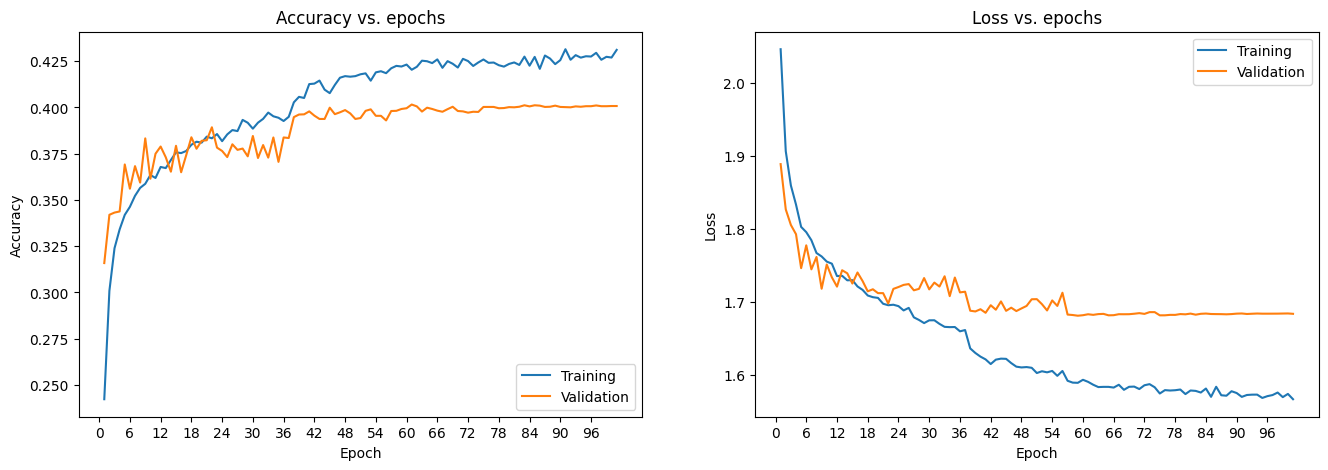

2022-08-09 09:32:07,576: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 09:32:17,906: INFO: test loss:1.6828
2022-08-09 09:32:17,907: INFO: test accuracy:0.4016
2022-08-09 09:32:17,908: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 09:32:17,909: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 09:32:17,910: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:32:17,911: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:32:17,912: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_20

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 09:32:22,519: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator


313/313 [==============================] - 3s 6ms/step


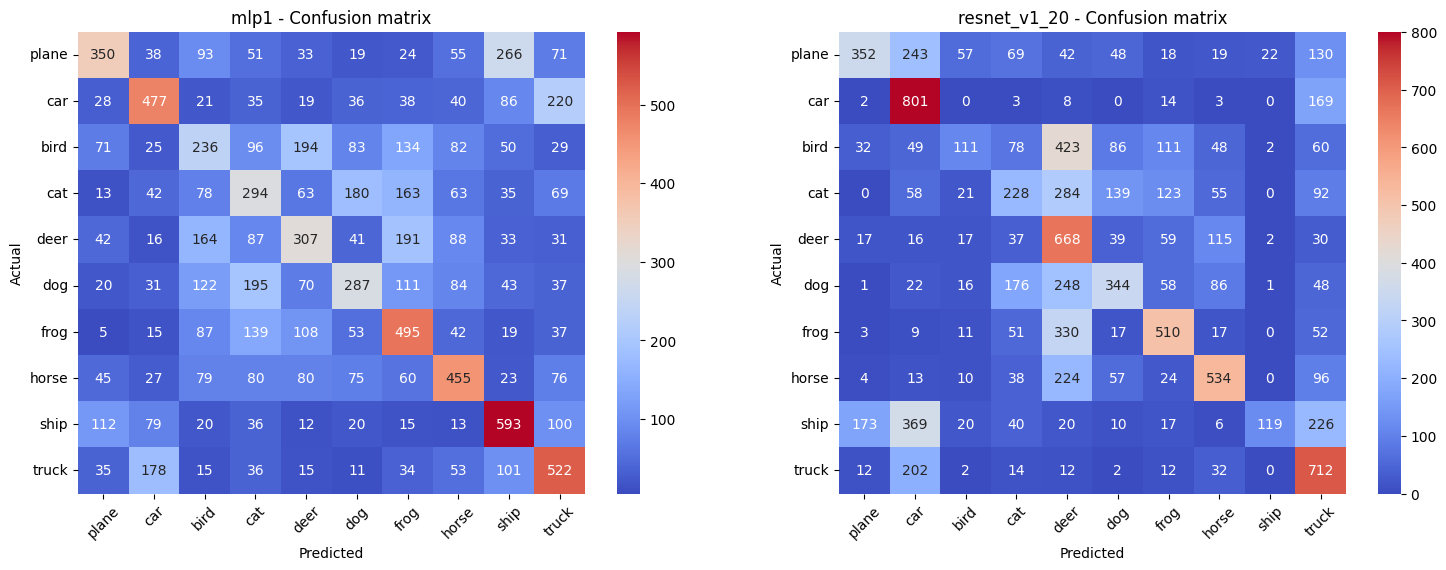

2022-08-09 09:32:29,552: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20


----------------------------------------sample analysis----------------------------------------


2022-08-09 09:32:34,312: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:32:34,319: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1
2022-08-09 09:32:35,156: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:32:35,159: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1
2022-08-09 09:32:36,208: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:32:36,212: INFO: loading model from /tf/eipi10/xuxiangwen.gi

1/1 [==============================] - 0s 120ms/step


2022-08-09 09:32:40,627: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f93c47151f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 10ms/step


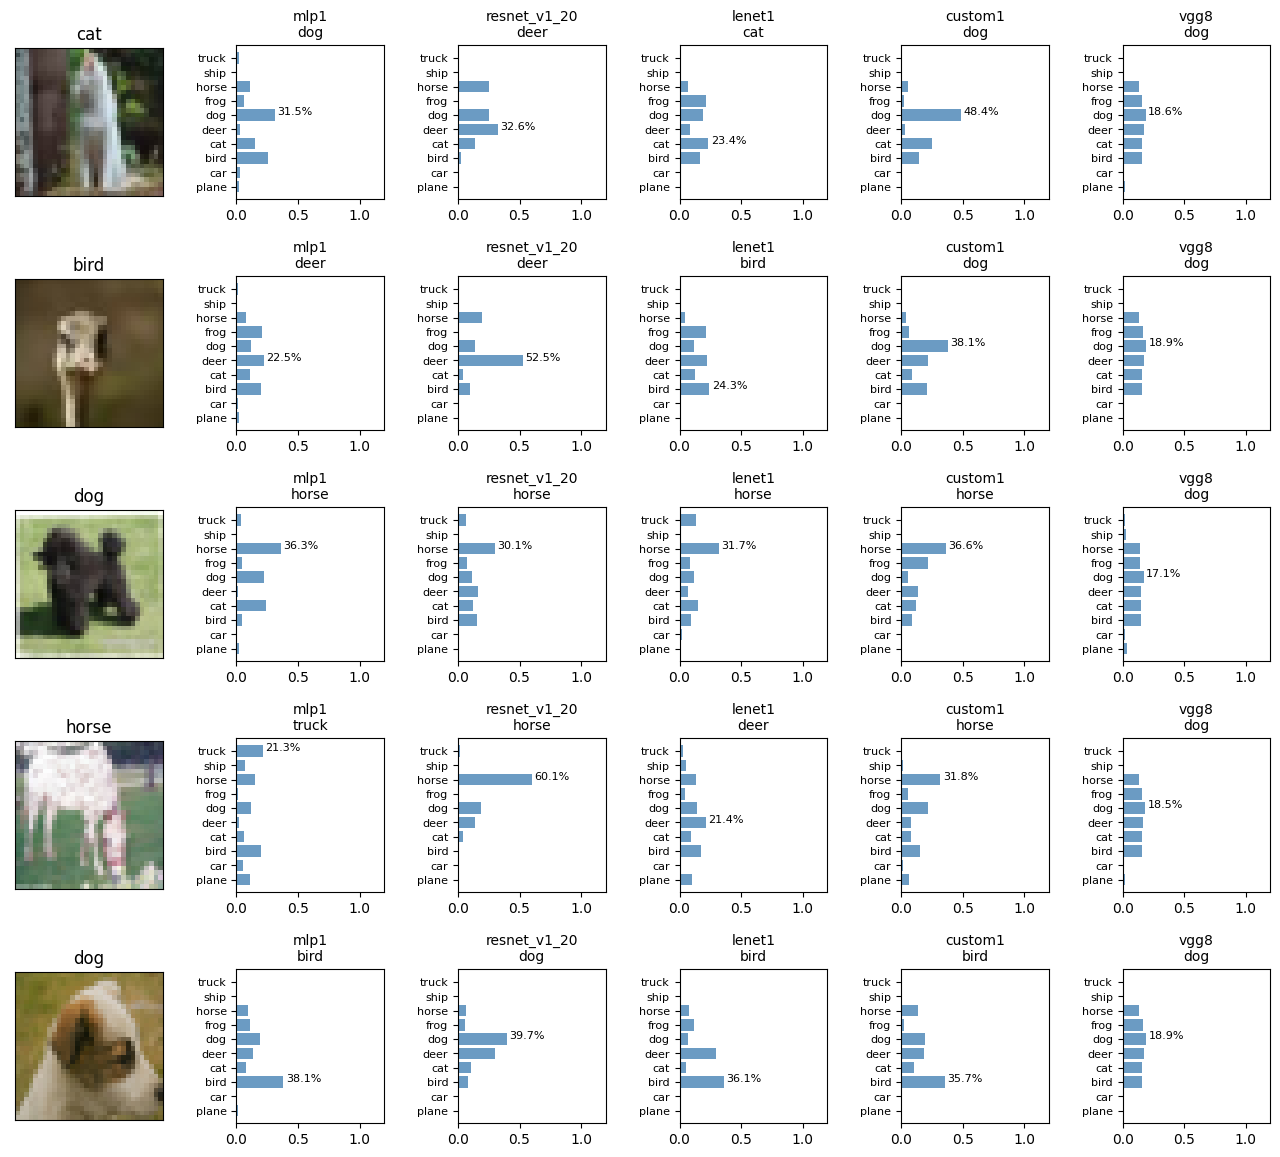

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1  resnet_v1_20  cifar10_0808_count_2000.ipynb         273066        26.0   
2        lenet1  cifar10_0808_count_2000.ipynb          83170         6.5   
3       custom1  cifar10_0808_count_2000.ipynb          73738         7.3   
4          mlp1  cifar10_0808_count_2000.ipynb         394634       222.9   
5          vgg8  cifar10_0808_count_2000.ipynb        1672906        12.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 05:50      1.7470     1.7895          0.4466         0.4379   
2  2022-08-09 09:22      1.5354     1.5682          0.4451         0.4310   
3  2022-08-09 09:23      1.6367     1.6534          0.4275         0.4239   
4  2022-08-09 09:32      1.5051     1.6828          0.4631         0.4016   
5  2022-08-09 05:49      2.2042     2.2043          0.1465         0.1465   

   train_auc  test_auc  
1     0.8925    0.8835  
2     0.8641    0.8557  
3     0.8599    0.8558  
4     0.8671    0.8286  
5     0.7410    0.7420

In [20]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2022-08-09 09:32:44,357: INFO: model_params.lenet1.dropout=0.2
2022-08-09 09:32:44,445: INFO: learning_rate=0.001
2022-08-09 09:32:44,446: INFO: model_params.lenet1.clip_value=None
2022-08-09 09:32:44,452: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0         
                                                               

2022-08-09 09:32:44,490: INFO: model_params.lenet1.epochs=120
2022-08-09 09:32:44,491: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1, monitor=val_accuracy)
2022-08-09 09:32:44,491: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 09:32:44,492: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 09:32:44,493: INFO: use LearningRateScheduler()
2022-08-09 09:32:44,493: INFO: steps_per_epoch=625
2022-08-09 09:32:44,494: INFO: start training
2022-08-09 09:32:44,495: INFO: use_class_weight=False


Epoch 1/120
619/625 [============================>.] - ETA: 0s - loss: 1.9270 - accuracy: 0.2996

2022-08-09 09:32:53,600: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:32:54,195: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 10s 14ms/step - loss: 1.9243 - accuracy: 0.3002 - val_loss: 1.7023 - val_accuracy: 0.3796 - lr: 0.0010
Epoch 2/120
621/625 [============================>.] - ETA: 0s - loss: 1.6138 - accuracy: 0.4158

2022-08-09 09:33:01,446: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:33:02,006: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 12ms/step - loss: 1.6134 - accuracy: 0.4160 - val_loss: 1.7129 - val_accuracy: 0.4078 - lr: 0.0010
Epoch 3/120
618/625 [============================>.] - ETA: 0s - loss: 1.5004 - accuracy: 0.4530

2022-08-09 09:33:08,149: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:33:08,728: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 7s 11ms/step - loss: 1.4988 - accuracy: 0.4536 - val_loss: 1.4368 - val_accuracy: 0.4851 - lr: 0.0010
Epoch 4/120
625/625 [==============================] - 6s 10ms/step - loss: 1.4140 - accuracy: 0.4885 - val_loss: 1.6320 - val_accuracy: 0.4277 - lr: 0.0010
Epoch 5/120
625/625 [==============================] - 6s 10ms/step - loss: 1.3536 - accuracy: 0.5134 - val_loss: 1.5757 - val_accuracy: 0.4545 - lr: 0.0010
Epoch 6/120
614/625 [============================>.] - ETA: 0s - loss: 1.3024 - accuracy: 0.5398

2022-08-09 09:33:26,002: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:33:26,589: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 5s 8ms/step - loss: 1.3012 - accuracy: 0.5401 - val_loss: 1.2886 - val_accuracy: 0.5413 - lr: 0.0010
Epoch 7/120
625/625 [==============================] - 6s 10ms/step - loss: 1.2587 - accuracy: 0.5491 - val_loss: 1.4049 - val_accuracy: 0.5165 - lr: 0.0010
Epoch 8/120
622/625 [============================>.] - ETA: 0s - loss: 1.2115 - accuracy: 0.5656

2022-08-09 09:33:40,341: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:33:40,926: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 1.2126 - accuracy: 0.5653 - val_loss: 1.2057 - val_accuracy: 0.5735 - lr: 0.0010
Epoch 9/120
625/625 [==============================] - 5s 7ms/step - loss: 1.1839 - accuracy: 0.5764 - val_loss: 1.3827 - val_accuracy: 0.5390 - lr: 0.0010
Epoch 10/120
625/625 [==============================] - 4s 7ms/step - loss: 1.1591 - accuracy: 0.5847 - val_loss: 1.4049 - val_accuracy: 0.5187 - lr: 0.0010
Epoch 11/120
625/625 [==============================] - 6s 10ms/step - loss: 1.1278 - accuracy: 0.6005 - val_loss: 1.2591 - val_accuracy: 0.5642 - lr: 0.0010
Epoch 12/120
625/625 [==============================] - 6s 10ms/step - loss: 1.1066 - accuracy: 0.6061 - val_loss: 1.2568 - val_accuracy: 0.5702 - lr: 0.0010
Epoch 13/120
619/625 [============================>.] - ETA: 0s - loss: 1.0801 - accuracy: 0.6130

2022-08-09 09:34:08,947: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:34:09,516: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 7s 12ms/step - loss: 1.0808 - accuracy: 0.6128 - val_loss: 1.1066 - val_accuracy: 0.6079 - lr: 0.0010
Epoch 14/120
622/625 [============================>.] - ETA: 0s - loss: 1.0559 - accuracy: 0.6240

2022-08-09 09:34:16,573: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:34:17,170: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 12ms/step - loss: 1.0567 - accuracy: 0.6238 - val_loss: 1.1202 - val_accuracy: 0.6167 - lr: 0.0010
Epoch 15/120
625/625 [==============================] - 6s 10ms/step - loss: 1.0524 - accuracy: 0.6260 - val_loss: 1.2104 - val_accuracy: 0.5965 - lr: 0.0010
Epoch 16/120
625/625 [==============================] - 6s 9ms/step - loss: 1.0235 - accuracy: 0.6370 - val_loss: 1.3532 - val_accuracy: 0.5546 - lr: 0.0010
Epoch 17/120
625/625 [==============================] - 3s 5ms/step - loss: 1.0073 - accuracy: 0.6409 - val_loss: 1.1767 - val_accuracy: 0.6052 - lr: 0.0010
Epoch 18/120
625/625 [==============================] - 6s 10ms/step - loss: 0.9913 - accuracy: 0.6460 - val_loss: 1.2384 - val_accuracy: 0.5846 - lr: 0.0010
Epoch 19/120
622/625 [============================>.] - ETA: 0s - loss: 0.9800 - accuracy: 0.6516

2022-08-09 09:34:46,259: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:34:46,845: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.9806 - accuracy: 0.6514 - val_loss: 1.0522 - val_accuracy: 0.6347 - lr: 0.0010
Epoch 20/120
625/625 [==============================] - 5s 8ms/step - loss: 0.9613 - accuracy: 0.6557 - val_loss: 1.1864 - val_accuracy: 0.6031 - lr: 0.0010
Epoch 21/120
625/625 [==============================] - 4s 6ms/step - loss: 0.9488 - accuracy: 0.6602 - val_loss: 1.1793 - val_accuracy: 0.6040 - lr: 0.0010
Epoch 22/120
625/625 [==============================] - 6s 10ms/step - loss: 0.9375 - accuracy: 0.6672 - val_loss: 1.1427 - val_accuracy: 0.6103 - lr: 0.0010
Epoch 23/120
625/625 [==============================] - 6s 10ms/step - loss: 0.9156 - accuracy: 0.6715 - val_loss: 1.2520 - val_accuracy: 0.5871 - lr: 0.0010
Epoch 24/120
622/625 [============================>.] - ETA: 0s - loss: 0.9157 - accuracy: 0.6748

2022-08-09 09:35:15,536: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:35:16,118: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 12ms/step - loss: 0.9164 - accuracy: 0.6745 - val_loss: 1.0758 - val_accuracy: 0.6353 - lr: 0.0010
Epoch 25/120
625/625 [==============================] - 6s 10ms/step - loss: 0.9141 - accuracy: 0.6718 - val_loss: 1.0694 - val_accuracy: 0.6347 - lr: 0.0010
Epoch 26/120
625/625 [==============================] - 6s 10ms/step - loss: 0.9034 - accuracy: 0.6786 - val_loss: 1.0950 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 27/120
613/625 [============================>.] - ETA: 0s - loss: 0.8898 - accuracy: 0.6835

2022-08-09 09:35:34,501: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:35:35,061: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 6s 10ms/step - loss: 0.8885 - accuracy: 0.6835 - val_loss: 1.0363 - val_accuracy: 0.6393 - lr: 0.0010
Epoch 28/120
625/625 [==============================] - 6s 9ms/step - loss: 0.8855 - accuracy: 0.6859 - val_loss: 1.2187 - val_accuracy: 0.5955 - lr: 0.0010
Epoch 29/120
625/625 [==============================] - 6s 10ms/step - loss: 0.8742 - accuracy: 0.6895 - val_loss: 1.2281 - val_accuracy: 0.5855 - lr: 0.0010
Epoch 30/120
624/625 [============================>.] - ETA: 0s - loss: 0.8652 - accuracy: 0.6896

2022-08-09 09:35:55,213: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:35:55,788: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 9s 14ms/step - loss: 0.8652 - accuracy: 0.6895 - val_loss: 1.0334 - val_accuracy: 0.6482 - lr: 0.0010
Epoch 31/120
625/625 [==============================] - 4s 7ms/step - loss: 0.8536 - accuracy: 0.6968 - val_loss: 1.1222 - val_accuracy: 0.6259 - lr: 0.0010
Epoch 32/120
625/625 [==============================] - 6s 10ms/step - loss: 0.8530 - accuracy: 0.6967 - val_loss: 1.1592 - val_accuracy: 0.5999 - lr: 0.0010
Epoch 33/120
625/625 [==============================] - 6s 10ms/step - loss: 0.8603 - accuracy: 0.6917 - val_loss: 1.0647 - val_accuracy: 0.6416 - lr: 0.0010
Epoch 34/120
625/625 [==============================] - 6s 9ms/step - loss: 0.8446 - accuracy: 0.6979 - val_loss: 1.0579 - val_accuracy: 0.6418 - lr: 0.0010
Epoch 35/120
625/625 [==============================] - 6s 10ms/step - loss: 0.8482 - accuracy: 0.6974 - val_loss: 1.0728 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 36/120
625/625 [==============================] - 6s 10ms/ste

2022-08-09 09:36:44,685: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:36:45,267: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.8217 - accuracy: 0.7017 - val_loss: 1.0192 - val_accuracy: 0.6498 - lr: 0.0010
Epoch 39/120
625/625 [==============================] - 6s 10ms/step - loss: 0.8139 - accuracy: 0.7114 - val_loss: 1.1435 - val_accuracy: 0.6168 - lr: 0.0010
Epoch 40/120
613/625 [============================>.] - ETA: 0s - loss: 0.8155 - accuracy: 0.7063

2022-08-09 09:36:56,995: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:36:57,561: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 6s 10ms/step - loss: 0.8150 - accuracy: 0.7065 - val_loss: 1.0064 - val_accuracy: 0.6553 - lr: 0.0010
Epoch 41/120
625/625 [==============================] - 6s 10ms/step - loss: 0.8008 - accuracy: 0.7123 - val_loss: 1.0812 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 42/120
625/625 [==============================] - 6s 10ms/step - loss: 0.7932 - accuracy: 0.7164 - val_loss: 1.1749 - val_accuracy: 0.6288 - lr: 0.0010
Epoch 43/120
625/625 [==============================] - 6s 10ms/step - loss: 0.7940 - accuracy: 0.7160 - val_loss: 1.0243 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 44/120
625/625 [==============================] - 3s 5ms/step - loss: 0.7903 - accuracy: 0.7155 - val_loss: 1.0217 - val_accuracy: 0.6540 - lr: 0.0010
Epoch 45/120
625/625 [==============================] - 6s 10ms/step - loss: 0.7972 - accuracy: 0.7131 - val_loss: 1.0758 - val_accuracy: 0.6418 - lr: 0.0010
Epoch 46/120
625/625 [==============================] - 6s 10ms/st

2022-08-09 09:37:52,299: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:37:52,881: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.7768 - accuracy: 0.7244 - val_loss: 1.0175 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 50/120
618/625 [============================>.] - ETA: 0s - loss: 0.7710 - accuracy: 0.7269

2022-08-09 09:37:59,686: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:38:00,272: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 7s 12ms/step - loss: 0.7713 - accuracy: 0.7268 - val_loss: 1.0057 - val_accuracy: 0.6637 - lr: 0.0010
Epoch 51/120
625/625 [==============================] - 6s 9ms/step - loss: 0.7700 - accuracy: 0.7222 - val_loss: 1.1138 - val_accuracy: 0.6377 - lr: 0.0010
Epoch 52/120
625/625 [==============================] - 6s 10ms/step - loss: 0.7663 - accuracy: 0.7290 - val_loss: 1.2966 - val_accuracy: 0.6060 - lr: 0.0010
Epoch 53/120
625/625 [==============================] - 6s 10ms/step - loss: 0.7790 - accuracy: 0.7239 - val_loss: 1.0496 - val_accuracy: 0.6497 - lr: 0.0010
Epoch 54/120
625/625 [==============================] - 6s 10ms/step - loss: 0.7490 - accuracy: 0.7301 - val_loss: 1.0609 - val_accuracy: 0.6487 - lr: 0.0010
Epoch 55/120
625/625 [==============================] - 6s 10ms/step - loss: 0.7505 - accuracy: 0.7326 - val_loss: 1.1077 - val_accuracy: 0.6404 - lr: 0.0010
Epoch 56/120
625/625 [==============================] - 6s 10ms/st

2022-08-09 09:39:18,493: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:39:19,099: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.6836 - accuracy: 0.7566 - val_loss: 0.9841 - val_accuracy: 0.6710 - lr: 1.0000e-04
Epoch 64/120
625/625 [==============================] - 3s 5ms/step - loss: 0.6719 - accuracy: 0.7631 - val_loss: 0.9948 - val_accuracy: 0.6680 - lr: 1.0000e-04
Epoch 65/120
625/625 [==============================] - 6s 9ms/step - loss: 0.6764 - accuracy: 0.7610 - val_loss: 0.9932 - val_accuracy: 0.6688 - lr: 1.0000e-04
Epoch 66/120
623/625 [============================>.] - ETA: 0s - loss: 0.6746 - accuracy: 0.7559

2022-08-09 09:39:35,499: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:39:36,080: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.6749 - accuracy: 0.7556 - val_loss: 0.9943 - val_accuracy: 0.6713 - lr: 1.0000e-04
Epoch 67/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6670 - accuracy: 0.7603 - val_loss: 1.0073 - val_accuracy: 0.6682 - lr: 1.0000e-04
Epoch 68/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6625 - accuracy: 0.7626 - val_loss: 1.0220 - val_accuracy: 0.6650 - lr: 1.0000e-04
Epoch 69/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6624 - accuracy: 0.7630 - val_loss: 1.0479 - val_accuracy: 0.6605 - lr: 1.0000e-04
Epoch 70/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6578 - accuracy: 0.7620 - val_loss: 1.0081 - val_accuracy: 0.6694 - lr: 1.0000e-04
Epoch 71/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6589 - accuracy: 0.7657 - val_loss: 1.0036 - val_accuracy: 0.6689 - lr: 1.0000e-04
Epoch 72/120
624/625 [===================

2022-08-09 09:40:14,942: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:40:15,516: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.6693 - accuracy: 0.7586 - val_loss: 1.0031 - val_accuracy: 0.6718 - lr: 1.0000e-04
Epoch 73/120
625/625 [==============================] - 5s 8ms/step - loss: 0.6517 - accuracy: 0.7667 - val_loss: 1.0011 - val_accuracy: 0.6691 - lr: 1.0000e-04
Epoch 74/120
625/625 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.7620

2022-08-09 09:40:25,368: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:40:25,953: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 6s 9ms/step - loss: 0.6622 - accuracy: 0.7620 - val_loss: 0.9852 - val_accuracy: 0.6735 - lr: 1.0000e-04
Epoch 75/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6532 - accuracy: 0.7655 - val_loss: 1.0107 - val_accuracy: 0.6679 - lr: 1.0000e-04
Epoch 76/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6473 - accuracy: 0.7677 - val_loss: 1.0035 - val_accuracy: 0.6688 - lr: 1.0000e-04
Epoch 77/120
625/625 [==============================] - 4s 7ms/step - loss: 0.6495 - accuracy: 0.7691 - val_loss: 1.0076 - val_accuracy: 0.6684 - lr: 1.0000e-04
Epoch 78/120
619/625 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.7668
Epoch 78: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
625/625 [==============================] - 4s 7ms/step - loss: 0.6519 - accuracy: 0.7670 - val_loss: 0.9944 - val_accuracy: 0.6705 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e

2022-08-09 09:40:55,290: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:40:55,882: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 9s 14ms/step - loss: 0.6458 - accuracy: 0.7660 - val_loss: 0.9843 - val_accuracy: 0.6750 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/120
624/625 [============================>.] - ETA: 0s - loss: 0.6532 - accuracy: 0.7660

2022-08-09 09:41:03,457: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:41:04,044: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.6536 - accuracy: 0.7660 - val_loss: 0.9823 - val_accuracy: 0.6757 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6488 - accuracy: 0.7656 - val_loss: 0.9847 - val_accuracy: 0.6739 - lr: 3.1623e-05
Epoch 00082: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 82/120
620/625 [============================>.] - ETA: 0s - loss: 0.6386 - accuracy: 0.7695

2022-08-09 09:41:17,886: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:41:18,471: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.6396 - accuracy: 0.7695 - val_loss: 0.9872 - val_accuracy: 0.6761 - lr: 3.1623e-05
Epoch 00083: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 83/120
625/625 [==============================] - 5s 7ms/step - loss: 0.6542 - accuracy: 0.7692 - val_loss: 0.9877 - val_accuracy: 0.6736 - lr: 3.1623e-05
Epoch 00084: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 84/120
625/625 [==============================] - 4s 6ms/step - loss: 0.6403 - accuracy: 0.7690 - val_loss: 0.9887 - val_accuracy: 0.6755 - lr: 3.1623e-05
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 85/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6534 - accuracy: 0.7685 - val_loss: 0.9883 - val_accuracy: 0.6740 - lr: 3.1623e-05
Epoch 00086: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 86/120
625/625 [==============================] - ETA: 0s - loss: 0.6316 - accuracy: 0.7742

2022-08-09 09:41:40,805: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:41:41,381: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.6316 - accuracy: 0.7742 - val_loss: 0.9793 - val_accuracy: 0.6763 - lr: 3.1623e-05
Epoch 00087: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 87/120
625/625 [==============================] - 6s 9ms/step - loss: 0.6350 - accuracy: 0.7705 - val_loss: 0.9824 - val_accuracy: 0.6746 - lr: 3.1623e-05
Epoch 00088: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 88/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6450 - accuracy: 0.7682 - val_loss: 0.9857 - val_accuracy: 0.6747 - lr: 3.1623e-05
Epoch 00089: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 89/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6407 - accuracy: 0.7715 - val_loss: 0.9817 - val_accuracy: 0.6749 - lr: 3.1623e-05
Epoch 00090: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 90/120
625/625 [==============================] - 6s 9ms/step - loss: 0.6420 - accuracy: 0.7681 - va

2022-08-09 09:43:05,277: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:43:06,274: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.6333 - accuracy: 0.7743 - val_loss: 0.9828 - val_accuracy: 0.6768 - lr: 1.0000e-05
Epoch 101/120
622/625 [============================>.] - ETA: 0s - loss: 0.6330 - accuracy: 0.7724
Epoch 101: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.
625/625 [==============================] - 6s 10ms/step - loss: 0.6337 - accuracy: 0.7719 - val_loss: 0.9830 - val_accuracy: 0.6761 - lr: 3.1623e-06
Epoch 00102: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 102/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6339 - accuracy: 0.7691 - val_loss: 0.9853 - val_accuracy: 0.6754 - lr: 3.1623e-06
Epoch 00103: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 103/120
625/625 [==============================] - 6s 9ms/step - loss: 0.6361 - accuracy: 0.7751 - val_loss: 0.9849 - val_accuracy: 0.6756 - lr: 3.1623e-06
Epoch 00104: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 104/

2022-08-09 09:44:48,812: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


2022-08-09 09:44:49,393: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.6347 - accuracy: 0.7738 - val_loss: 0.9833 - val_accuracy: 0.6770 - lr: 5.0000e-07
Epoch 00118: Still keep learning rate 5e-07 instead of 1e-06
Epoch 118/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6409 - accuracy: 0.7682 - val_loss: 0.9837 - val_accuracy: 0.6759 - lr: 5.0000e-07
Epoch 00119: Still keep learning rate 5e-07 instead of 1e-06
Epoch 119/120
625/625 [==============================] - 6s 9ms/step - loss: 0.6447 - accuracy: 0.7695 - val_loss: 0.9837 - val_accuracy: 0.6763 - lr: 5.0000e-07
Epoch 00120: Still keep learning rate 5e-07 instead of 1e-06
Epoch 120/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6350 - accuracy: 0.7738 - val_loss: 0.9837 - val_accuracy: 0.6764 - lr: 5.0000e-07


2022-08-09 09:45:07,897: INFO: finish training [elapsed time: 743.40 seconds]


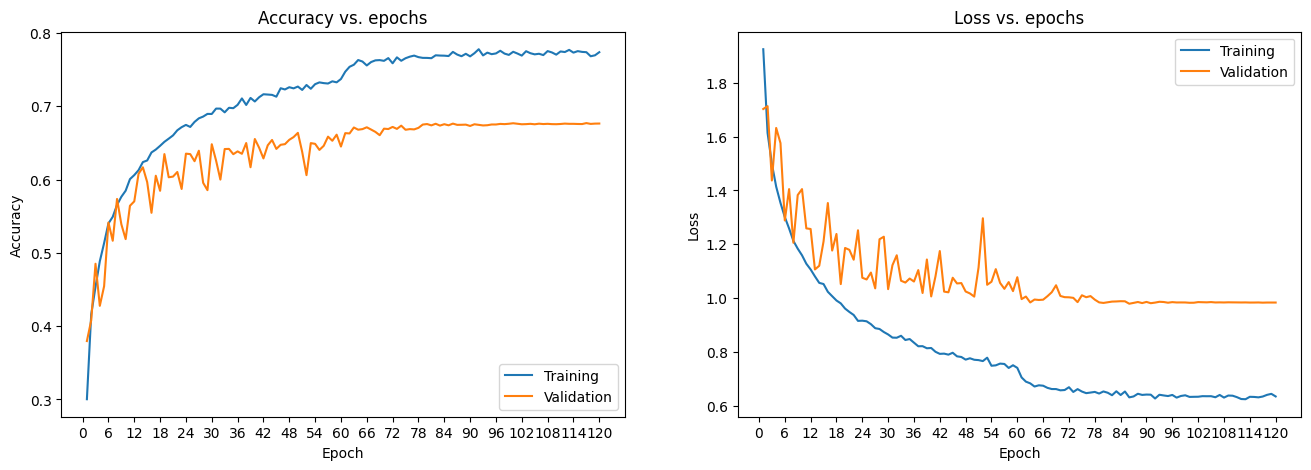

2022-08-09 09:45:08,395: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-09 09:45:20,412: INFO: test loss:0.9833
2022-08-09 09:45:20,413: INFO: test accuracy:0.6770
2022-08-09 09:45:20,415: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 09:45:20,417: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 09:45:20,418: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:45:20,421: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:45:20,422: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_20

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 09:45:25,365: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator


313/313 [==============================] - 3s 6ms/step


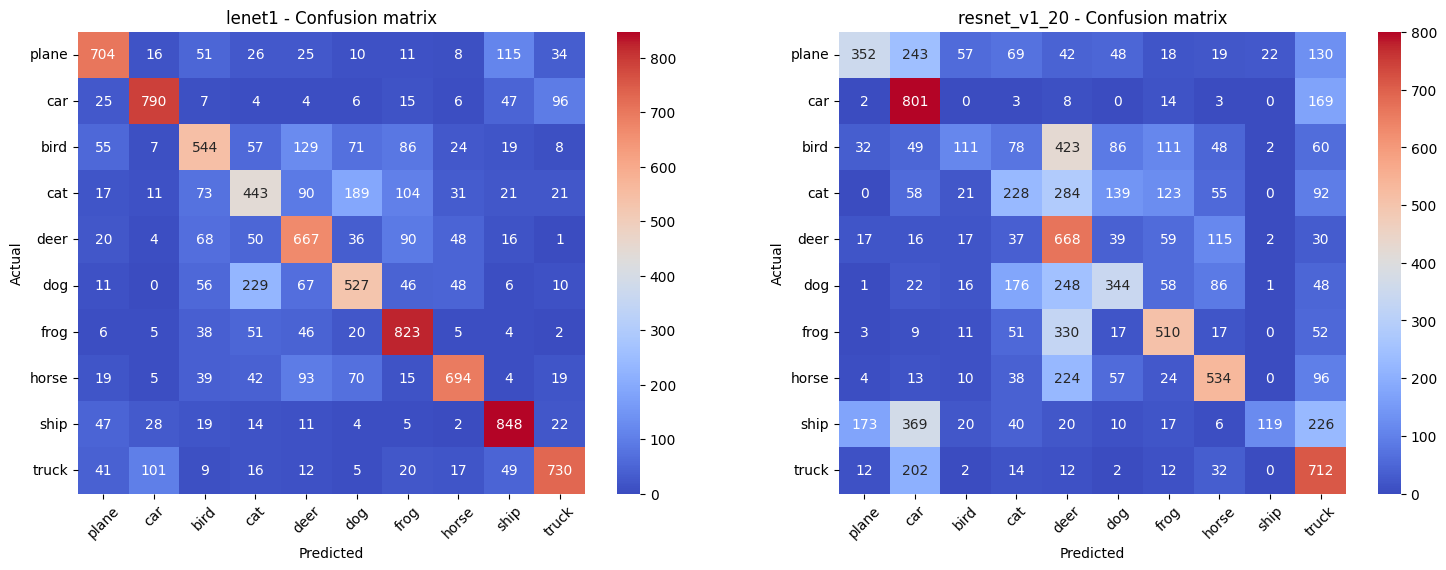

2022-08-09 09:45:31,923: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20


----------------------------------------sample analysis----------------------------------------


2022-08-09 09:45:37,066: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:45:37,070: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1
2022-08-09 09:45:38,054: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:45:38,057: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1
2022-08-09 09:45:38,390: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:45:38,392: INFO: loading model from /tf/eipi10/xuxiangwen.gith

1/1 [==============================] - 0s 43ms/step


2022-08-09 09:45:42,770: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f9430291af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 11ms/step


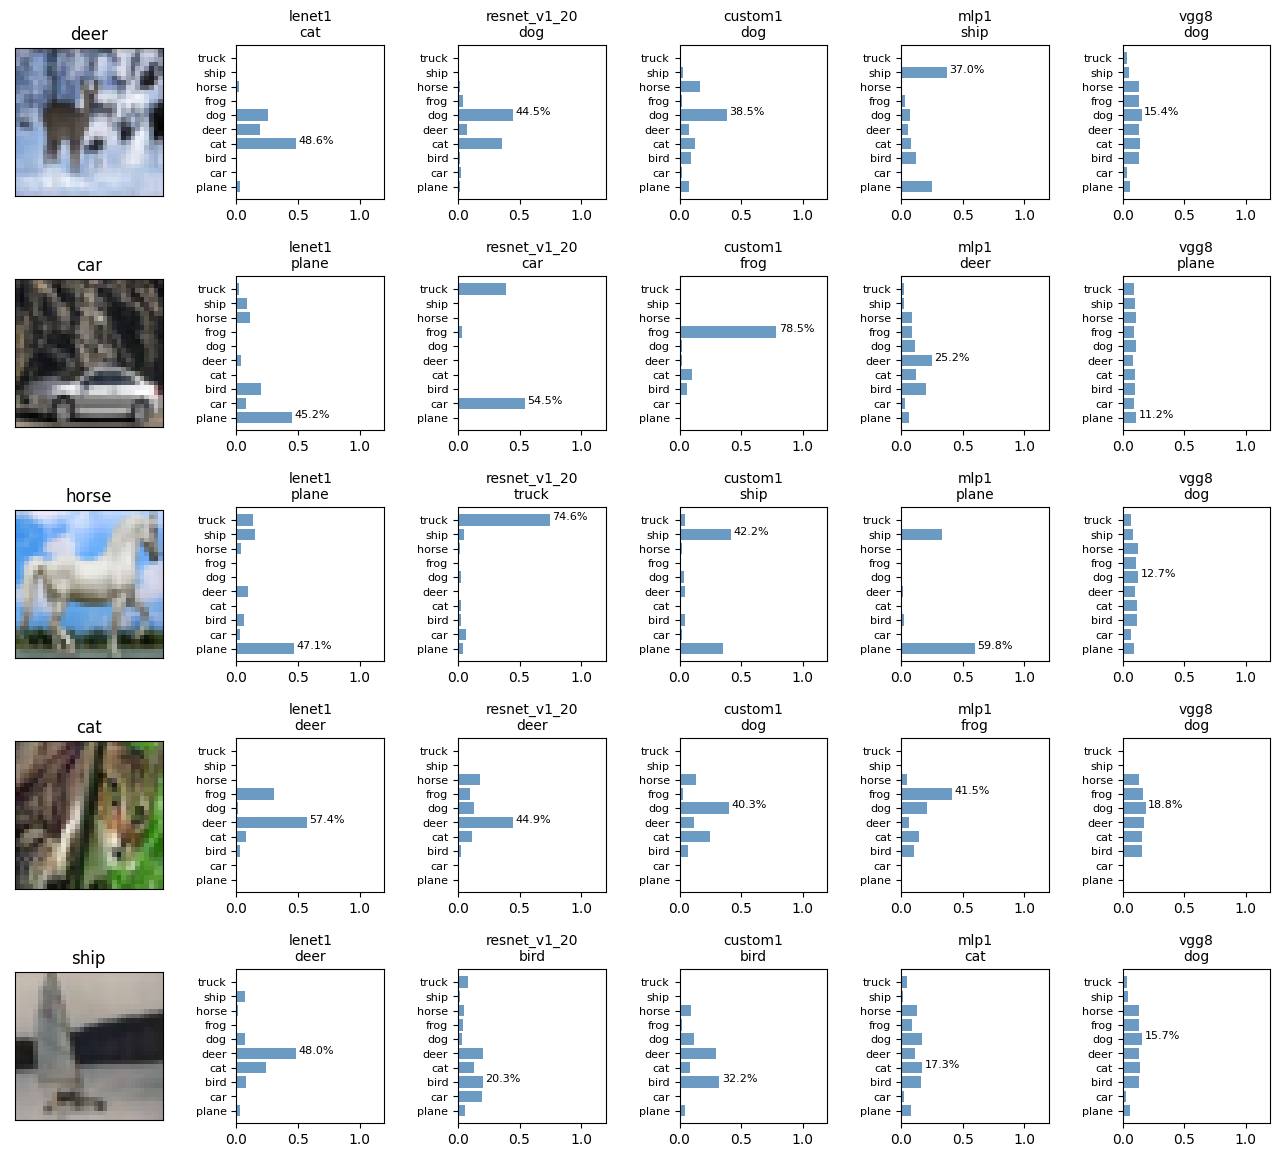

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1        lenet1  cifar10_0808_count_2000.ipynb          83170       743.4   
2  resnet_v1_20  cifar10_0808_count_2000.ipynb         273066        26.0   
3       custom1  cifar10_0808_count_2000.ipynb          73738         7.3   
4          mlp1  cifar10_0808_count_2000.ipynb         394634       222.9   
5          vgg8  cifar10_0808_count_2000.ipynb        1672906        12.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 09:45      0.3296     0.9833          0.8987         0.6770   
2  2022-08-09 05:50      1.7470     1.7895          0.4466         0.4379   
3  2022-08-09 09:23      1.6367     1.6534          0.4275         0.4239   
4  2022-08-09 09:32      1.5051     1.6828          0.4631         0.4016   
5  2022-08-09 05:49      2.2042     2.2043          0.1465         0.1465   

   train_auc  test_auc  
1     0.9944    0.9474  
2     0.8925    0.8835  
3     0.8599    0.8558  
4     0.8671    0.8286  
5     0.7410    0.7420

In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2022-08-09 09:45:47,199: INFO: model_params.custom1.dropout=0.2
2022-08-09 09:45:47,301: INFO: learning_rate=0.001
2022-08-09 09:45:47,302: INFO: model_params.custom1.clip_value=None
2022-08-09 09:45:47,309: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0         
                                                              

2022-08-09 09:45:47,340: INFO: model_params.custom1.epochs=120
2022-08-09 09:45:47,341: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1, monitor=val_accuracy)
2022-08-09 09:45:47,341: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 09:45:47,342: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 09:45:47,342: INFO: use LearningRateScheduler()
2022-08-09 09:45:47,343: INFO: steps_per_epoch=625
2022-08-09 09:45:47,344: INFO: start training
2022-08-09 09:45:47,344: INFO: use_class_weight=False


Epoch 1/120
620/625 [============================>.] - ETA: 0s - loss: 1.8453 - accuracy: 0.3389

2022-08-09 09:45:55,722: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:45:56,392: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 9s 14ms/step - loss: 1.8432 - accuracy: 0.3394 - val_loss: 1.5172 - val_accuracy: 0.4536 - lr: 0.0010
Epoch 2/120
622/625 [============================>.] - ETA: 0s - loss: 1.4949 - accuracy: 0.4585

2022-08-09 09:46:04,130: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:46:04,795: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 1.4941 - accuracy: 0.4588 - val_loss: 1.4026 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 3/120
618/625 [============================>.] - ETA: 0s - loss: 1.3645 - accuracy: 0.5029

2022-08-09 09:46:12,184: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:46:12,848: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 1.3630 - accuracy: 0.5037 - val_loss: 1.2758 - val_accuracy: 0.5389 - lr: 0.0010
Epoch 4/120
624/625 [============================>.] - ETA: 0s - loss: 1.2691 - accuracy: 0.5474

2022-08-09 09:46:20,231: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:46:20,891: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 1.2689 - accuracy: 0.5473 - val_loss: 1.2766 - val_accuracy: 0.5463 - lr: 0.0010
Epoch 5/120
625/625 [==============================] - 6s 9ms/step - loss: 1.1997 - accuracy: 0.5755 - val_loss: 1.3319 - val_accuracy: 0.5374 - lr: 0.0010
Epoch 6/120
625/625 [==============================] - 6s 9ms/step - loss: 1.1273 - accuracy: 0.5998 - val_loss: 1.2983 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 7/120
625/625 [==============================] - ETA: 0s - loss: 1.0782 - accuracy: 0.6169

2022-08-09 09:46:40,738: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:46:41,401: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 9s 14ms/step - loss: 1.0782 - accuracy: 0.6169 - val_loss: 1.1396 - val_accuracy: 0.5929 - lr: 0.0010
Epoch 8/120
625/625 [==============================] - ETA: 0s - loss: 1.0302 - accuracy: 0.6345

2022-08-09 09:46:48,758: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:46:49,418: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 1.0302 - accuracy: 0.6345 - val_loss: 1.0365 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 9/120
625/625 [==============================] - 4s 6ms/step - loss: 0.9986 - accuracy: 0.6464 - val_loss: 1.0464 - val_accuracy: 0.6305 - lr: 0.0010
Epoch 10/120
619/625 [============================>.] - ETA: 0s - loss: 0.9692 - accuracy: 0.6594

2022-08-09 09:47:00,779: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:47:01,447: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.9691 - accuracy: 0.6594 - val_loss: 1.0438 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 11/120
625/625 [==============================] - 6s 10ms/step - loss: 0.9384 - accuracy: 0.6653 - val_loss: 1.0906 - val_accuracy: 0.6258 - lr: 0.0010
Epoch 12/120
625/625 [==============================] - 6s 9ms/step - loss: 0.9166 - accuracy: 0.6725 - val_loss: 1.0566 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 13/120
625/625 [==============================] - 6s 10ms/step - loss: 0.8967 - accuracy: 0.6817 - val_loss: 1.0970 - val_accuracy: 0.6328 - lr: 0.0010
Epoch 14/120
622/625 [============================>.] - ETA: 0s - loss: 0.8713 - accuracy: 0.6935

2022-08-09 09:47:26,586: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:47:27,621: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.8720 - accuracy: 0.6935 - val_loss: 0.9970 - val_accuracy: 0.6571 - lr: 0.0010
Epoch 15/120
625/625 [==============================] - 5s 8ms/step - loss: 0.8641 - accuracy: 0.6963 - val_loss: 1.1327 - val_accuracy: 0.6174 - lr: 0.0010
Epoch 16/120
625/625 [==============================] - 4s 7ms/step - loss: 0.8403 - accuracy: 0.7038 - val_loss: 1.0428 - val_accuracy: 0.6461 - lr: 0.0010
Epoch 17/120
619/625 [============================>.] - ETA: 0s - loss: 0.8307 - accuracy: 0.7052

2022-08-09 09:47:44,110: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:47:44,788: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.8312 - accuracy: 0.7050 - val_loss: 0.9447 - val_accuracy: 0.6809 - lr: 0.0010
Epoch 18/120
625/625 [==============================] - 6s 10ms/step - loss: 0.8142 - accuracy: 0.7097 - val_loss: 1.1628 - val_accuracy: 0.6182 - lr: 0.0010
Epoch 19/120
620/625 [============================>.] - ETA: 0s - loss: 0.7927 - accuracy: 0.7218

2022-08-09 09:47:57,847: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:47:58,524: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 12ms/step - loss: 0.7928 - accuracy: 0.7212 - val_loss: 0.9477 - val_accuracy: 0.6817 - lr: 0.0010
Epoch 20/120
621/625 [============================>.] - ETA: 0s - loss: 0.7906 - accuracy: 0.7172

2022-08-09 09:48:05,905: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:48:06,588: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.7904 - accuracy: 0.7171 - val_loss: 0.9634 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 21/120
625/625 [==============================] - 6s 10ms/step - loss: 0.7801 - accuracy: 0.7234 - val_loss: 0.9220 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 22/120
625/625 [==============================] - 4s 6ms/step - loss: 0.7647 - accuracy: 0.7308 - val_loss: 1.1389 - val_accuracy: 0.6358 - lr: 0.0010
Epoch 23/120
625/625 [==============================] - 5s 9ms/step - loss: 0.7613 - accuracy: 0.7333 - val_loss: 1.0776 - val_accuracy: 0.6547 - lr: 0.0010
Epoch 24/120
624/625 [============================>.] - ETA: 0s - loss: 0.7540 - accuracy: 0.7316

2022-08-09 09:48:29,594: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:48:30,651: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 9s 14ms/step - loss: 0.7541 - accuracy: 0.7315 - val_loss: 0.9463 - val_accuracy: 0.6868 - lr: 0.0010
Epoch 25/120
625/625 [==============================] - 6s 9ms/step - loss: 0.7422 - accuracy: 0.7368 - val_loss: 0.9856 - val_accuracy: 0.6692 - lr: 0.0010
Epoch 26/120
625/625 [==============================] - 4s 6ms/step - loss: 0.7328 - accuracy: 0.7418 - val_loss: 0.9676 - val_accuracy: 0.6781 - lr: 0.0010
Epoch 27/120
624/625 [============================>.] - ETA: 0s - loss: 0.7286 - accuracy: 0.7406

2022-08-09 09:48:47,456: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:48:48,124: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 12ms/step - loss: 0.7285 - accuracy: 0.7405 - val_loss: 0.9478 - val_accuracy: 0.6888 - lr: 0.0010
Epoch 28/120
625/625 [==============================] - 6s 9ms/step - loss: 0.7191 - accuracy: 0.7454 - val_loss: 0.9799 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 29/120
620/625 [============================>.] - ETA: 0s - loss: 0.7130 - accuracy: 0.7467

2022-08-09 09:49:01,421: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:49:02,092: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.7129 - accuracy: 0.7469 - val_loss: 0.8908 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 30/120
624/625 [============================>.] - ETA: 0s - loss: 0.6975 - accuracy: 0.7515

2022-08-09 09:49:09,465: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:49:10,124: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.6980 - accuracy: 0.7513 - val_loss: 0.8866 - val_accuracy: 0.7044 - lr: 0.0010
Epoch 31/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6898 - accuracy: 0.7545 - val_loss: 0.9885 - val_accuracy: 0.6825 - lr: 0.0010
Epoch 32/120
625/625 [==============================] - 5s 8ms/step - loss: 0.6938 - accuracy: 0.7547 - val_loss: 0.9130 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 33/120
625/625 [==============================] - 4s 7ms/step - loss: 0.6830 - accuracy: 0.7594 - val_loss: 1.1006 - val_accuracy: 0.6511 - lr: 0.0010
Epoch 34/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6832 - accuracy: 0.7534 - val_loss: 1.0143 - val_accuracy: 0.6782 - lr: 0.0010
Epoch 35/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6764 - accuracy: 0.7599 - val_loss: 0.9236 - val_accuracy: 0.6991 - lr: 0.0010
Epoch 36/120
625/625 [==============================] - 6s 10ms/ste

2022-08-09 09:49:50,737: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:49:51,854: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 9s 14ms/step - loss: 0.6554 - accuracy: 0.7636 - val_loss: 0.8688 - val_accuracy: 0.7145 - lr: 0.0010
Epoch 38/120
625/625 [==============================] - 6s 9ms/step - loss: 0.6521 - accuracy: 0.7667 - val_loss: 0.9060 - val_accuracy: 0.6970 - lr: 0.0010
Epoch 39/120
625/625 [==============================] - 6s 9ms/step - loss: 0.6498 - accuracy: 0.7686 - val_loss: 0.9312 - val_accuracy: 0.6987 - lr: 0.0010
Epoch 40/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6419 - accuracy: 0.7727 - val_loss: 0.9641 - val_accuracy: 0.6937 - lr: 0.0010
Epoch 41/120
625/625 [==============================] - 6s 9ms/step - loss: 0.6425 - accuracy: 0.7705 - val_loss: 0.8737 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 42/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6448 - accuracy: 0.7683 - val_loss: 0.8910 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 43/120
625/625 [==============================] - 6s 9ms/step 

2022-08-09 09:50:40,654: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:50:41,327: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.6270 - accuracy: 0.7760 - val_loss: 0.8690 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 46/120
625/625 [==============================] - 4s 7ms/step - loss: 0.6216 - accuracy: 0.7800 - val_loss: 0.9091 - val_accuracy: 0.7097 - lr: 0.0010
Epoch 47/120
625/625 [==============================] - 5s 8ms/step - loss: 0.6235 - accuracy: 0.7804 - val_loss: 0.9147 - val_accuracy: 0.7014 - lr: 0.0010
Epoch 48/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6123 - accuracy: 0.7833 - val_loss: 0.8917 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 49/120
625/625 [==============================] - 6s 10ms/step - loss: 0.6140 - accuracy: 0.7796 - val_loss: 0.9586 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 50/120
625/625 [==============================] - 6s 9ms/step - loss: 0.6086 - accuracy: 0.7836 - val_loss: 1.0195 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 51/120
625/625 [==============================] - 6s 9ms/step 

2022-08-09 09:51:27,624: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:51:28,261: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.5576 - accuracy: 0.8013 - val_loss: 0.8661 - val_accuracy: 0.7212 - lr: 3.1623e-04
Epoch 00054: Still keep learning rate 0.0003162 instead of 0.001
Epoch 54/120
622/625 [============================>.] - ETA: 0s - loss: 0.5588 - accuracy: 0.8028

2022-08-09 09:51:33,932: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:51:34,620: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 0.5587 - accuracy: 0.8030 - val_loss: 0.8340 - val_accuracy: 0.7281 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/120
618/625 [============================>.] - ETA: 0s - loss: 0.5398 - accuracy: 0.8052

2022-08-09 09:51:42,464: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:51:43,186: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 9s 14ms/step - loss: 0.5394 - accuracy: 0.8052 - val_loss: 0.8593 - val_accuracy: 0.7285 - lr: 3.1623e-04
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/120
625/625 [==============================] - 6s 10ms/step - loss: 0.5360 - accuracy: 0.8124 - val_loss: 0.8762 - val_accuracy: 0.7262 - lr: 3.1623e-04
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/120
625/625 [==============================] - 6s 9ms/step - loss: 0.5455 - accuracy: 0.8035 - val_loss: 0.8825 - val_accuracy: 0.7248 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/120
625/625 [==============================] - 6s 10ms/step - loss: 0.5245 - accuracy: 0.8124 - val_loss: 0.8501 - val_accuracy: 0.7248 - lr: 3.1623e-04
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
Epoch 59/120
622/625 [============================>.] - ETA: 0s - loss: 0.5276 - accuracy: 0.8098

2022-08-09 09:52:08,393: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:52:09,089: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.5278 - accuracy: 0.8097 - val_loss: 0.8357 - val_accuracy: 0.7364 - lr: 3.1623e-04
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
Epoch 60/120
625/625 [==============================] - 6s 9ms/step - loss: 0.5144 - accuracy: 0.8141 - val_loss: 0.8826 - val_accuracy: 0.7262 - lr: 3.1623e-04
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.0003162.
Epoch 61/120
625/625 [==============================] - 6s 10ms/step - loss: 0.5008 - accuracy: 0.8203 - val_loss: 0.8476 - val_accuracy: 0.7359 - lr: 1.0000e-04
Epoch 62/120
625/625 [==============================] - 6s 9ms/step - loss: 0.4963 - accuracy: 0.8230 - val_loss: 0.8425 - val_accuracy: 0.7364 - lr: 1.0000e-04
Epoch 63/120
625/625 [==============================] - 6s 9ms/step - loss: 0.5022 - accuracy: 0.8175 - val_loss: 0.8522 - val_accuracy: 0.7336 - lr: 1.0000e-04
Epoch 64/120
625/625 [==============================] - E

2022-08-09 09:52:39,862: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:52:40,537: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.5008 - accuracy: 0.8204 - val_loss: 0.8478 - val_accuracy: 0.7365 - lr: 1.0000e-04
Epoch 65/120
624/625 [============================>.] - ETA: 0s - loss: 0.5042 - accuracy: 0.8176

2022-08-09 09:52:47,927: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:52:48,617: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.5040 - accuracy: 0.8177 - val_loss: 0.8263 - val_accuracy: 0.7394 - lr: 1.0000e-04
Epoch 66/120
625/625 [==============================] - 6s 9ms/step - loss: 0.4908 - accuracy: 0.8237 - val_loss: 0.8395 - val_accuracy: 0.7388 - lr: 1.0000e-04
Epoch 67/120
625/625 [==============================] - 6s 10ms/step - loss: 0.4913 - accuracy: 0.8255 - val_loss: 0.8564 - val_accuracy: 0.7351 - lr: 1.0000e-04
Epoch 68/120
625/625 [==============================] - 6s 10ms/step - loss: 0.4934 - accuracy: 0.8233 - val_loss: 0.8531 - val_accuracy: 0.7364 - lr: 1.0000e-04
Epoch 69/120
625/625 [==============================] - 6s 9ms/step - loss: 0.4951 - accuracy: 0.8235 - val_loss: 0.8596 - val_accuracy: 0.7349 - lr: 1.0000e-04
Epoch 70/120
625/625 [==============================] - 6s 10ms/step - loss: 0.4818 - accuracy: 0.8283 - val_loss: 0.8483 - val_accuracy: 0.7362 - lr: 1.0000e-04
Epoch 71/120
625/625 [=====================

2022-08-09 09:53:59,104: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:53:59,814: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.4802 - accuracy: 0.8253 - val_loss: 0.8393 - val_accuracy: 0.7399 - lr: 1.0000e-04
Epoch 78/120
625/625 [==============================] - 6s 10ms/step - loss: 0.4905 - accuracy: 0.8246 - val_loss: 0.8427 - val_accuracy: 0.7385 - lr: 1.0000e-04
Epoch 79/120
625/625 [==============================] - 6s 10ms/step - loss: 0.4807 - accuracy: 0.8267 - val_loss: 0.8762 - val_accuracy: 0.7331 - lr: 1.0000e-04
Epoch 80/120
620/625 [============================>.] - ETA: 0s - loss: 0.4822 - accuracy: 0.8295
Epoch 80: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
625/625 [==============================] - 6s 9ms/step - loss: 0.4826 - accuracy: 0.8296 - val_loss: 0.8533 - val_accuracy: 0.7380 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/120
625/625 [==============================] - 6s 10ms/step - loss: 0.4749 - accuracy: 0.8300 - val_loss: 0.8482 - val_accuracy: 

2022-08-09 09:54:42,823: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:54:43,491: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.4708 - accuracy: 0.8314 - val_loss: 0.8417 - val_accuracy: 0.7403 - lr: 3.1623e-05
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 85/120
625/625 [==============================] - 6s 9ms/step - loss: 0.4772 - accuracy: 0.8289 - val_loss: 0.8452 - val_accuracy: 0.7396 - lr: 3.1623e-05
Epoch 00086: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 86/120
625/625 [==============================] - 6s 9ms/step - loss: 0.4720 - accuracy: 0.8306 - val_loss: 0.8437 - val_accuracy: 0.7384 - lr: 3.1623e-05
Epoch 00087: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 87/120
625/625 [==============================] - 6s 10ms/step - loss: 0.4681 - accuracy: 0.8346 - val_loss: 0.8432 - val_accuracy: 0.7395 - lr: 3.1623e-05
Epoch 00088: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 88/120
625/625 [==============================] - 6s 9ms/step - loss: 0.4743 - accuracy: 0.8292 - val

2022-08-09 09:56:17,157: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


2022-08-09 09:56:17,826: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1/assets


625/625 [==============================] - 8s 13ms/step - loss: 0.4662 - accuracy: 0.8349 - val_loss: 0.8459 - val_accuracy: 0.7404 - lr: 3.1623e-06
Epoch 00101: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 101/120
625/625 [==============================] - 6s 10ms/step - loss: 0.4796 - accuracy: 0.8256 - val_loss: 0.8472 - val_accuracy: 0.7396 - lr: 3.1623e-06
Epoch 00102: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 102/120
625/625 [==============================] - 6s 10ms/step - loss: 0.4810 - accuracy: 0.8273 - val_loss: 0.8486 - val_accuracy: 0.7389 - lr: 3.1623e-06
Epoch 00103: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 103/120
625/625 [==============================] - 6s 10ms/step - loss: 0.4690 - accuracy: 0.8315 - val_loss: 0.8466 - val_accuracy: 0.7400 - lr: 3.1623e-06
Epoch 00104: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 104/120
625/625 [==============================] - 6s 9ms/step - loss: 0.4758 - accuracy: 0.8278 - val_l

2022-08-09 09:58:11,697: INFO: finish training [elapsed time: 744.35 seconds]


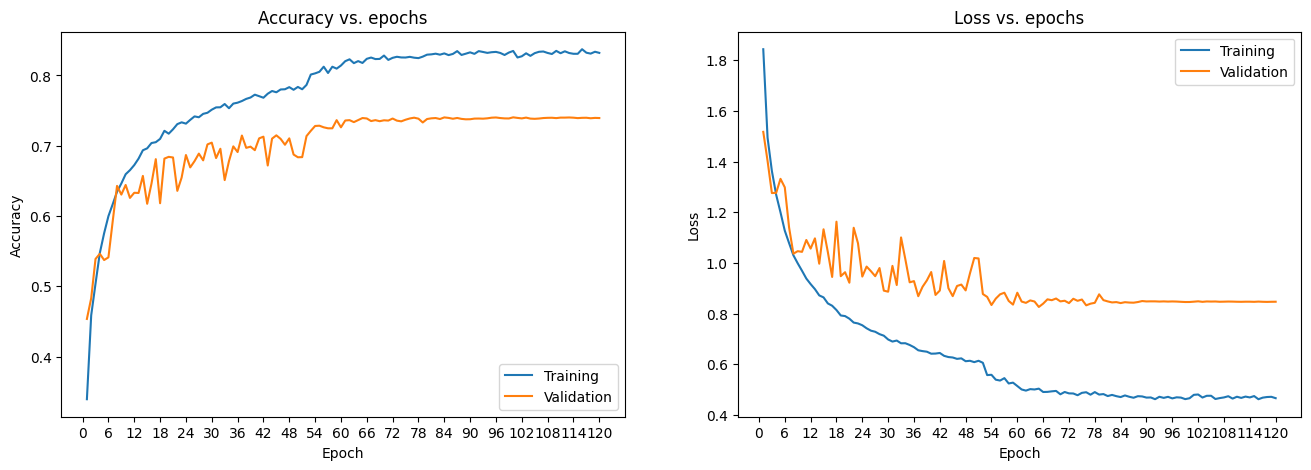

2022-08-09 09:58:12,138: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 09:58:24,443: INFO: test loss:0.8459
2022-08-09 09:58:24,444: INFO: test accuracy:0.7404
2022-08-09 09:58:24,445: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 09:58:24,447: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 09:58:24,448: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:58:24,449: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:58:24,449: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_20

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 09:58:25,247: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator


313/313 [==============================] - 1s 3ms/step


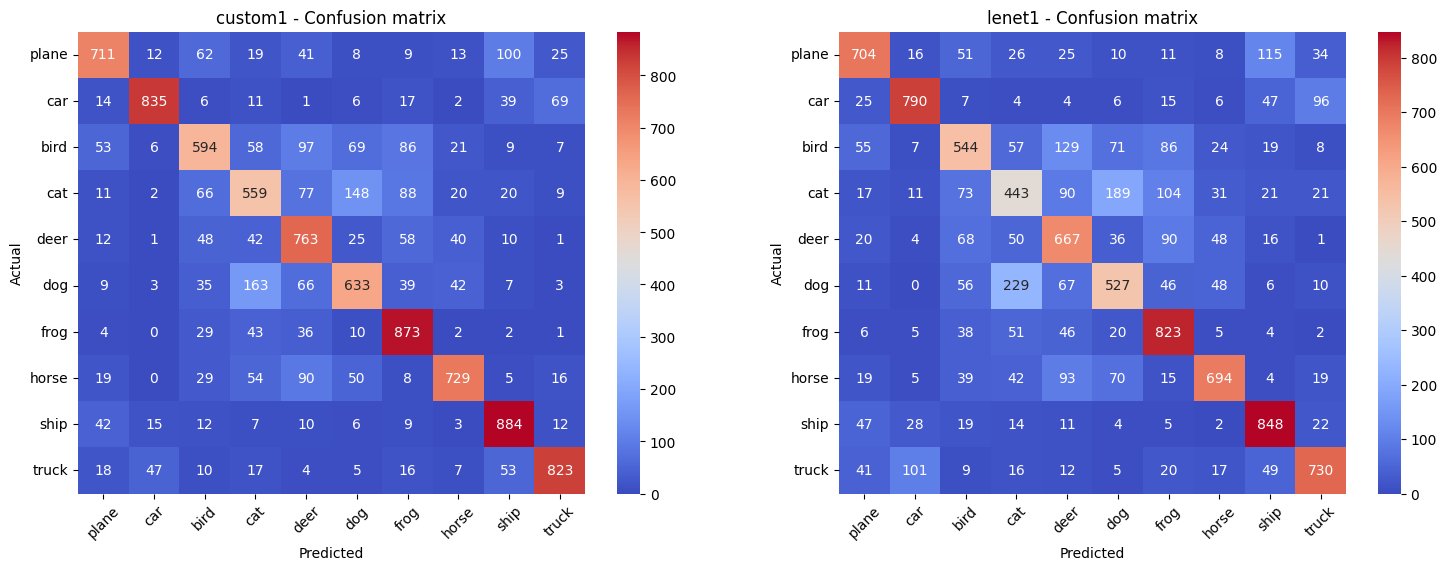

2022-08-09 09:58:30,740: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-09 09:58:31,629: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:58:31,633: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20
2022-08-09 09:58:36,400: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:58:36,414: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/mlp1
2022-08-09 09:58:36,729: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 09:58:36,731: INFO: loading model from /tf/eipi10/xuxiangwen

1/1 [==============================] - 0s 10ms/step


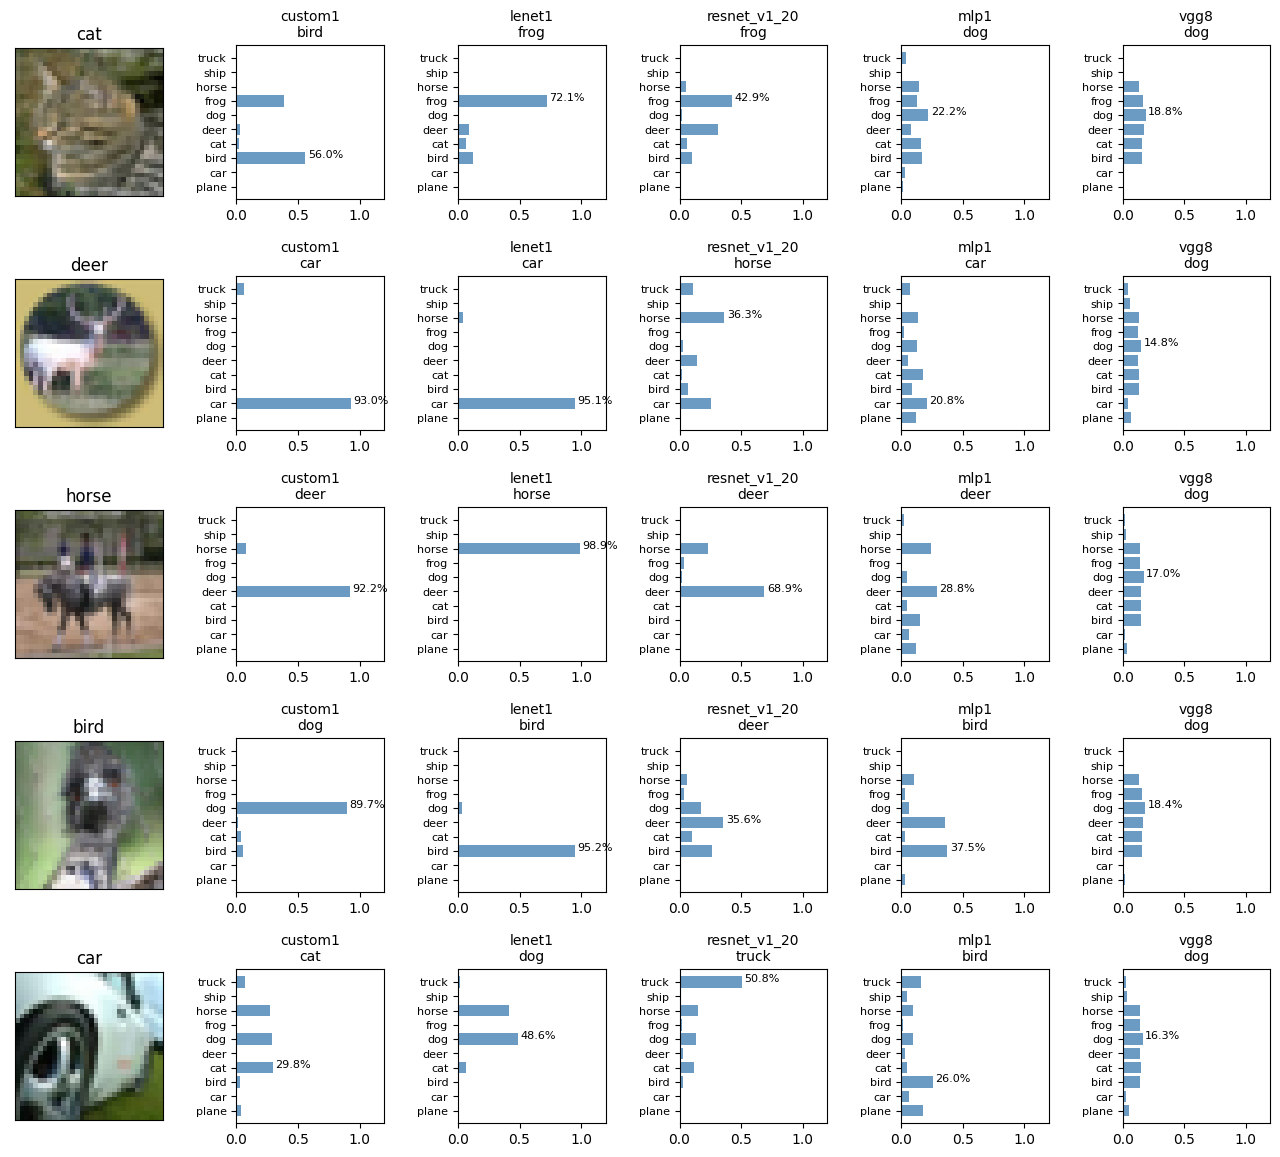

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1       custom1  cifar10_0808_count_2000.ipynb          73738       744.4   
2        lenet1  cifar10_0808_count_2000.ipynb          83170       743.4   
3  resnet_v1_20  cifar10_0808_count_2000.ipynb         273066        26.0   
4          mlp1  cifar10_0808_count_2000.ipynb         394634       222.9   
5          vgg8  cifar10_0808_count_2000.ipynb        1672906        12.4   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 09:58      0.2042     0.8459          0.9377         0.7404   
2  2022-08-09 09:45      0.3296     0.9833          0.8987         0.6770   
3  2022-08-09 05:50      1.7470     1.7895          0.4466         0.4379   
4  2022-08-09 09:32      1.5051     1.6828          0.4631         0.4016   
5  2022-08-09 05:49      2.2042     2.2043          0.1465         0.1465   

   train_auc  test_auc  
1     0.9978    0.9643  
2     0.9944    0.9474  
3     0.8925    0.8835  
4     0.8671    0.8286  
5     0.7410    0.7420

In [22]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2022-08-09 09:58:44,992: INFO: model_params.vgg8.dropout=0.4


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 09:58:45,162: INFO: learning_rate=0.001
2022-08-09 09:58:45,162: INFO: model_params.vgg8.clip_value=None
2022-08-09 09:58:45,169: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                                 
 block1_bn2 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                         

2022-08-09 09:58:45,231: INFO: model_params.vgg8.epochs=120
2022-08-09 09:58:45,232: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8, monitor=val_accuracy)
2022-08-09 09:58:45,233: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 09:58:45,234: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 09:58:45,235: INFO: use LearningRateScheduler()
2022-08-09 09:58:45,236: INFO: steps_per_epoch=625
2022-08-09 09:58:45,236: INFO: start training
2022-08-09 09:58:45,237: INFO: use_class_weight=False


Epoch 1/120
625/625 [==============================] - ETA: 0s - loss: 2.1277 - accuracy: 0.1832

2022-08-09 09:59:02,761: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 09:59:03,855: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 19s 26ms/step - loss: 2.1277 - accuracy: 0.1832 - val_loss: 1.8796 - val_accuracy: 0.2574 - lr: 0.0010
Epoch 2/120
624/625 [============================>.] - ETA: 0s - loss: 1.9408 - accuracy: 0.2345

2022-08-09 09:59:18,738: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 09:59:20,150: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 1.9407 - accuracy: 0.2345 - val_loss: 1.7307 - val_accuracy: 0.3208 - lr: 0.0010
Epoch 3/120
625/625 [==============================] - 13s 21ms/step - loss: 1.8708 - accuracy: 0.2708 - val_loss: 1.9568 - val_accuracy: 0.2747 - lr: 0.0010
Epoch 4/120
624/625 [============================>.] - ETA: 0s - loss: 1.8023 - accuracy: 0.2937

2022-08-09 09:59:48,239: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 09:59:49,346: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 1.8022 - accuracy: 0.2937 - val_loss: 1.6202 - val_accuracy: 0.3623 - lr: 0.0010
Epoch 5/120
625/625 [==============================] - ETA: 0s - loss: 1.7607 - accuracy: 0.2997

2022-08-09 10:00:04,363: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:00:05,488: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 1.7607 - accuracy: 0.2997 - val_loss: 1.4910 - val_accuracy: 0.4136 - lr: 0.0010
Epoch 6/120
625/625 [==============================] - ETA: 0s - loss: 1.7277 - accuracy: 0.3133

2022-08-09 10:00:21,324: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:00:22,461: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 1.7277 - accuracy: 0.3133 - val_loss: 1.3940 - val_accuracy: 0.4703 - lr: 0.0010
Epoch 7/120
624/625 [============================>.] - ETA: 0s - loss: 1.6851 - accuracy: 0.3423

2022-08-09 10:00:37,443: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:00:38,539: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 1.6847 - accuracy: 0.3425 - val_loss: 1.3805 - val_accuracy: 0.4731 - lr: 0.0010
Epoch 8/120
625/625 [==============================] - ETA: 0s - loss: 1.6151 - accuracy: 0.3729

2022-08-09 10:00:54,272: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:00:55,369: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 1.6151 - accuracy: 0.3729 - val_loss: 1.3255 - val_accuracy: 0.4951 - lr: 0.0010
Epoch 9/120
623/625 [============================>.] - ETA: 0s - loss: 1.5636 - accuracy: 0.3867

2022-08-09 10:01:10,340: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:01:11,456: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 1.5636 - accuracy: 0.3867 - val_loss: 1.2638 - val_accuracy: 0.5204 - lr: 0.0010
Epoch 10/120
625/625 [==============================] - ETA: 0s - loss: 1.5004 - accuracy: 0.4182

2022-08-09 10:01:26,387: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:01:27,486: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 1.5004 - accuracy: 0.4182 - val_loss: 1.2843 - val_accuracy: 0.5423 - lr: 0.0010
Epoch 11/120
625/625 [==============================] - ETA: 0s - loss: 1.4511 - accuracy: 0.4348

2022-08-09 10:01:43,147: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:01:44,264: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 1.4511 - accuracy: 0.4348 - val_loss: 1.2262 - val_accuracy: 0.5645 - lr: 0.0010
Epoch 12/120
623/625 [============================>.] - ETA: 0s - loss: 1.4050 - accuracy: 0.4587

2022-08-09 10:01:56,037: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:01:57,161: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 13s 21ms/step - loss: 1.4048 - accuracy: 0.4586 - val_loss: 1.1838 - val_accuracy: 0.5658 - lr: 0.0010
Epoch 13/120
625/625 [==============================] - ETA: 0s - loss: 1.3199 - accuracy: 0.4811

2022-08-09 10:02:12,871: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:02:14,030: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 1.3199 - accuracy: 0.4811 - val_loss: 1.0501 - val_accuracy: 0.6115 - lr: 0.0010
Epoch 14/120
625/625 [==============================] - ETA: 0s - loss: 1.2887 - accuracy: 0.5057

2022-08-09 10:02:29,284: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:02:30,379: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 1.2887 - accuracy: 0.5057 - val_loss: 0.9745 - val_accuracy: 0.6770 - lr: 0.0010
Epoch 15/120
625/625 [==============================] - 12s 19ms/step - loss: 1.2368 - accuracy: 0.5288 - val_loss: 0.9509 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 16/120
625/625 [==============================] - ETA: 0s - loss: 1.1800 - accuracy: 0.5617

2022-08-09 10:02:57,990: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:02:59,102: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 1.1800 - accuracy: 0.5617 - val_loss: 0.9515 - val_accuracy: 0.6831 - lr: 0.0010
Epoch 17/120
625/625 [==============================] - ETA: 0s - loss: 1.0974 - accuracy: 0.6030

2022-08-09 10:03:14,097: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:03:15,234: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 1.0974 - accuracy: 0.6030 - val_loss: 0.8885 - val_accuracy: 0.7029 - lr: 0.0010
Epoch 18/120
625/625 [==============================] - 13s 21ms/step - loss: 1.0286 - accuracy: 0.6295 - val_loss: 0.8766 - val_accuracy: 0.6938 - lr: 0.0010
Epoch 19/120
625/625 [==============================] - 12s 20ms/step - loss: 0.9859 - accuracy: 0.6442 - val_loss: 0.8737 - val_accuracy: 0.6895 - lr: 0.0010
Epoch 20/120
625/625 [==============================] - 13s 20ms/step - loss: 0.9636 - accuracy: 0.6503 - val_loss: 0.9281 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 21/120
623/625 [============================>.] - ETA: 0s - loss: 0.9246 - accuracy: 0.6686

2022-08-09 10:04:08,016: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:04:09,146: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 25ms/step - loss: 0.9251 - accuracy: 0.6687 - val_loss: 0.8082 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 22/120
625/625 [==============================] - 13s 21ms/step - loss: 0.9066 - accuracy: 0.6704 - val_loss: 0.9248 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 23/120
625/625 [==============================] - ETA: 0s - loss: 0.8503 - accuracy: 0.6927

2022-08-09 10:04:37,417: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:04:38,535: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 0.8503 - accuracy: 0.6927 - val_loss: 0.7598 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 24/120
625/625 [==============================] - ETA: 0s - loss: 0.8049 - accuracy: 0.7104

2022-08-09 10:04:53,918: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:04:55,044: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 0.8049 - accuracy: 0.7104 - val_loss: 0.7747 - val_accuracy: 0.7438 - lr: 0.0010
Epoch 25/120
623/625 [============================>.] - ETA: 0s - loss: 0.7852 - accuracy: 0.7170

2022-08-09 10:05:10,770: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:05:11,885: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 0.7854 - accuracy: 0.7169 - val_loss: 0.7311 - val_accuracy: 0.7602 - lr: 0.0010
Epoch 26/120
624/625 [============================>.] - ETA: 0s - loss: 0.7295 - accuracy: 0.7317

2022-08-09 10:05:26,646: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:05:27,748: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 25ms/step - loss: 0.7301 - accuracy: 0.7315 - val_loss: 0.7055 - val_accuracy: 0.7696 - lr: 0.0010
Epoch 27/120
625/625 [==============================] - 13s 20ms/step - loss: 0.7060 - accuracy: 0.7426 - val_loss: 0.7448 - val_accuracy: 0.7693 - lr: 0.0010
Epoch 28/120
625/625 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.7523

2022-08-09 10:05:55,895: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:05:57,033: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 26ms/step - loss: 0.6831 - accuracy: 0.7523 - val_loss: 0.7459 - val_accuracy: 0.7745 - lr: 0.0010
Epoch 29/120
625/625 [==============================] - 13s 20ms/step - loss: 0.6259 - accuracy: 0.7727 - val_loss: 0.8196 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 30/120
625/625 [==============================] - 13s 20ms/step - loss: 0.5862 - accuracy: 0.7913 - val_loss: 0.7861 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 31/120
625/625 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.8037

2022-08-09 10:06:37,449: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:06:38,594: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 0.5489 - accuracy: 0.8037 - val_loss: 0.7469 - val_accuracy: 0.7846 - lr: 0.0010
Epoch 32/120
625/625 [==============================] - 13s 20ms/step - loss: 0.5182 - accuracy: 0.8184 - val_loss: 0.9359 - val_accuracy: 0.7586 - lr: 0.0010
Epoch 33/120
625/625 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.8305

2022-08-09 10:07:06,500: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:07:07,633: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 0.4883 - accuracy: 0.8305 - val_loss: 0.7052 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 34/120
625/625 [==============================] - 12s 20ms/step - loss: 0.4710 - accuracy: 0.8331 - val_loss: 0.8105 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 35/120
625/625 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.8428

2022-08-09 10:07:35,880: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:07:36,995: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 0.4500 - accuracy: 0.8428 - val_loss: 0.7605 - val_accuracy: 0.7943 - lr: 0.0010
Epoch 36/120
625/625 [==============================] - 13s 21ms/step - loss: 0.4160 - accuracy: 0.8540 - val_loss: 0.7861 - val_accuracy: 0.7881 - lr: 0.0010
Epoch 37/120
625/625 [==============================] - 13s 20ms/step - loss: 0.3887 - accuracy: 0.8656 - val_loss: 0.8293 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 38/120
625/625 [==============================] - 13s 20ms/step - loss: 0.3752 - accuracy: 0.8706 - val_loss: 0.8101 - val_accuracy: 0.7776 - lr: 0.0010
Epoch 39/120
625/625 [==============================] - 13s 21ms/step - loss: 0.3531 - accuracy: 0.8780 - val_loss: 0.9494 - val_accuracy: 0.7606 - lr: 0.0010
Epoch 40/120
625/625 [==============================] - 13s 20ms/step - loss: 0.3450 - accuracy: 0.8808 - val_loss: 0.8070 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 41/120
625/625 [==============================] - 13s

2022-08-09 10:09:08,449: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:09:09,549: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 25ms/step - loss: 0.3174 - accuracy: 0.8867 - val_loss: 0.7513 - val_accuracy: 0.7997 - lr: 0.0010
Epoch 43/120
625/625 [==============================] - 13s 21ms/step - loss: 0.2977 - accuracy: 0.8955 - val_loss: 0.7854 - val_accuracy: 0.7993 - lr: 0.0010
Epoch 44/120
625/625 [==============================] - 13s 20ms/step - loss: 0.2801 - accuracy: 0.9025 - val_loss: 0.8891 - val_accuracy: 0.7846 - lr: 0.0010
Epoch 45/120
625/625 [==============================] - 13s 20ms/step - loss: 0.2659 - accuracy: 0.9067 - val_loss: 0.8959 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 46/120
625/625 [==============================] - 13s 21ms/step - loss: 0.2638 - accuracy: 0.9097 - val_loss: 0.8796 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 47/120
625/625 [==============================] - 13s 20ms/step - loss: 0.2541 - accuracy: 0.9125 - val_loss: 0.8774 - val_accuracy: 0.7952 - lr: 0.0010
Epoch 48/120
625/625 [==============================] - ETA

2022-08-09 10:10:41,528: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:10:42,646: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 0.1900 - accuracy: 0.9348 - val_loss: 0.8290 - val_accuracy: 0.8160 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/120
625/625 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9417

2022-08-09 10:10:57,892: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:10:59,019: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 0.1708 - accuracy: 0.9417 - val_loss: 0.7624 - val_accuracy: 0.8287 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/120
625/625 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.9454

2022-08-09 10:11:14,592: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:11:15,705: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 0.1578 - accuracy: 0.9454 - val_loss: 0.7624 - val_accuracy: 0.8318 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/120
625/625 [==============================] - 13s 20ms/step - loss: 0.1531 - accuracy: 0.9475 - val_loss: 0.8402 - val_accuracy: 0.8212 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/120
625/625 [==============================] - 13s 21ms/step - loss: 0.1363 - accuracy: 0.9541 - val_loss: 0.8469 - val_accuracy: 0.8265 - lr: 3.1623e-04
Epoch 00054: Still keep learning rate 0.0003162 instead of 0.001
Epoch 54/120
625/625 [==============================] - 13s 20ms/step - loss: 0.1301 - accuracy: 0.9555 - val_loss: 0.8144 - val_accuracy: 0.8317 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/120
625/625 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9551

2022-08-09 10:12:09,012: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:12:10,128: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 0.1319 - accuracy: 0.9551 - val_loss: 0.7889 - val_accuracy: 0.8346 - lr: 3.1623e-04
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/120
625/625 [==============================] - 13s 20ms/step - loss: 0.1201 - accuracy: 0.9568 - val_loss: 0.8375 - val_accuracy: 0.8340 - lr: 3.1623e-04
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/120
625/625 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9596

2022-08-09 10:12:38,024: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:12:39,133: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 0.1252 - accuracy: 0.9596 - val_loss: 0.8326 - val_accuracy: 0.8349 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/120
625/625 [==============================] - 13s 20ms/step - loss: 0.1139 - accuracy: 0.9616 - val_loss: 0.8553 - val_accuracy: 0.8330 - lr: 3.1623e-04
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
Epoch 59/120
625/625 [==============================] - 13s 20ms/step - loss: 0.1199 - accuracy: 0.9597 - val_loss: 0.8610 - val_accuracy: 0.8299 - lr: 3.1623e-04
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
Epoch 60/120
625/625 [==============================] - 13s 20ms/step - loss: 0.1077 - accuracy: 0.9637 - val_loss: 0.8242 - val_accuracy: 0.8320 - lr: 3.1623e-04
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.0003162.
Epoch 61/120
625/625 [==============================] - ETA: 0s - loss: 0.0929 - a

2022-08-09 10:13:32,752: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:13:33,869: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 0.0929 - accuracy: 0.9686 - val_loss: 0.8292 - val_accuracy: 0.8392 - lr: 1.0000e-04
Epoch 62/120
625/625 [==============================] - 13s 20ms/step - loss: 0.0945 - accuracy: 0.9672 - val_loss: 0.8379 - val_accuracy: 0.8390 - lr: 1.0000e-04
Epoch 63/120
625/625 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9708

2022-08-09 10:14:01,652: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:14:02,740: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets



Epoch 63: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
625/625 [==============================] - 16s 26ms/step - loss: 0.0869 - accuracy: 0.9708 - val_loss: 0.8482 - val_accuracy: 0.8400 - lr: 3.1623e-05
Epoch 00064: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 64/120
623/625 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.9708

2022-08-09 10:14:18,132: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:14:19,257: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 26ms/step - loss: 0.0850 - accuracy: 0.9707 - val_loss: 0.8432 - val_accuracy: 0.8405 - lr: 3.1623e-05
Epoch 00065: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 65/120
623/625 [============================>.] - ETA: 0s - loss: 0.0855 - accuracy: 0.9731

2022-08-09 10:14:34,438: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:14:35,534: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 0.0857 - accuracy: 0.9730 - val_loss: 0.8459 - val_accuracy: 0.8413 - lr: 3.1623e-05
Epoch 00066: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 66/120
625/625 [==============================] - 13s 21ms/step - loss: 0.0742 - accuracy: 0.9753 - val_loss: 0.8497 - val_accuracy: 0.8407 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/120
625/625 [==============================] - 13s 21ms/step - loss: 0.0855 - accuracy: 0.9712 - val_loss: 0.8533 - val_accuracy: 0.8396 - lr: 3.1623e-05
Epoch 00068: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 68/120
623/625 [============================>.] - ETA: 0s - loss: 0.0806 - accuracy: 0.9732

2022-08-09 10:15:17,051: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


2022-08-09 10:15:18,193: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 0.0807 - accuracy: 0.9732 - val_loss: 0.8481 - val_accuracy: 0.8418 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/120
625/625 [==============================] - 13s 20ms/step - loss: 0.0805 - accuracy: 0.9717 - val_loss: 0.8497 - val_accuracy: 0.8411 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/120
625/625 [==============================] - 13s 21ms/step - loss: 0.0816 - accuracy: 0.9728 - val_loss: 0.8524 - val_accuracy: 0.8410 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/120
625/625 [==============================] - 13s 21ms/step - loss: 0.0783 - accuracy: 0.9725 - val_loss: 0.8561 - val_accuracy: 0.8403 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/120
625/625 [==============================] - 13s 20ms/step - loss: 0.0768 - accuracy: 0.97

625/625 [==============================] - 7s 12ms/step - loss: 0.0704 - accuracy: 0.9763 - val_loss: 0.8726 - val_accuracy: 0.8407 - lr: 3.1623e-06
Epoch 00105: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 105/120
625/625 [==============================] - 9s 15ms/step - loss: 0.0699 - accuracy: 0.9762 - val_loss: 0.8710 - val_accuracy: 0.8403 - lr: 3.1623e-06
Epoch 00106: LearningRateScheduler reducing learning rate to 1e-06 from 3.2e-06.
Epoch 106/120
625/625 [==============================] - 9s 15ms/step - loss: 0.0685 - accuracy: 0.9761 - val_loss: 0.8695 - val_accuracy: 0.8407 - lr: 1.0000e-06
Epoch 107/120
625/625 [==============================] - 9s 15ms/step - loss: 0.0674 - accuracy: 0.9769 - val_loss: 0.8734 - val_accuracy: 0.8404 - lr: 1.0000e-06
Epoch 108/120
624/625 [============================>.] - ETA: 0s - loss: 0.0722 - accuracy: 0.9741
Epoch 108: ReduceLROnPlateau reducing learning rate to 5e-07.
625/625 [==============================] - 9s 15ms/step -

2022-08-09 10:22:04,414: INFO: finish training [elapsed time: 1399.18 seconds]


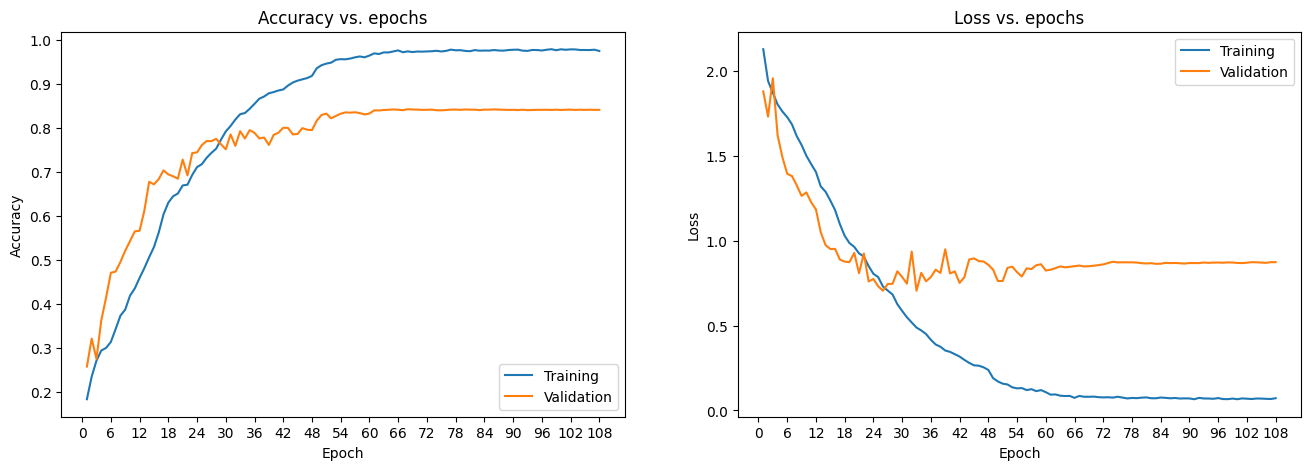

2022-08-09 10:22:04,843: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-09 10:22:18,763: INFO: test loss:0.8481
2022-08-09 10:22:18,764: INFO: test accuracy:0.8418
2022-08-09 10:22:18,767: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 10:22:18,768: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 10:22:18,769: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 10:22:18,770: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 10:22:18,771: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_20

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 10:22:19,754: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator


313/313 [==============================] - 1s 3ms/step


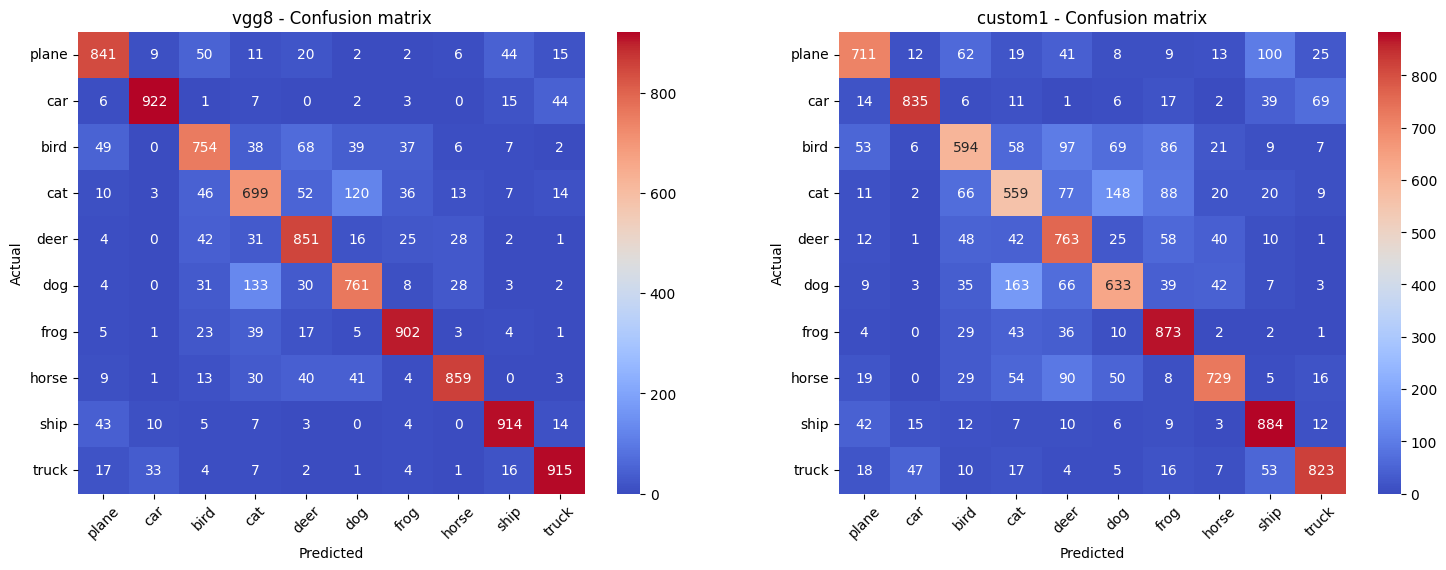

2022-08-09 10:22:24,996: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1


----------------------------------------sample analysis----------------------------------------


2022-08-09 10:22:25,984: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 10:22:25,985: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1
2022-08-09 10:22:27,418: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 10:22:27,420: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20
2022-08-09 10:22:31,903: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 10:22:31,906: INFO: loading model from /tf/eipi10/xuxiangw

1/1 [==============================] - 0s 9ms/step


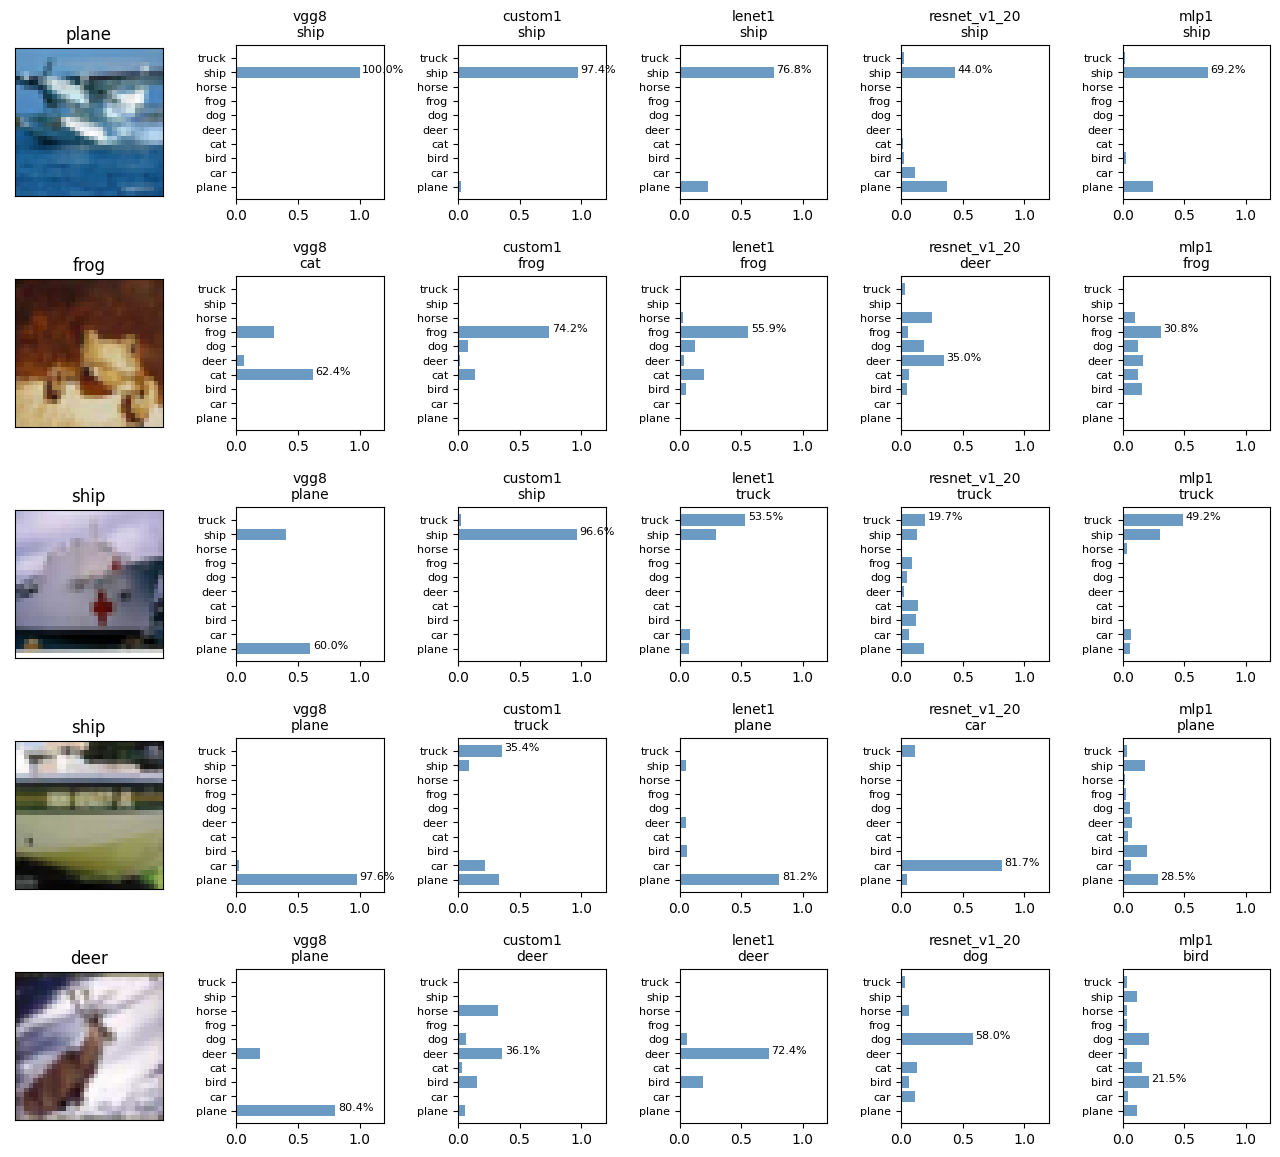

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1          vgg8  cifar10_0808_count_2000.ipynb        1672906      1399.2   
2       custom1  cifar10_0808_count_2000.ipynb          73738       744.4   
3        lenet1  cifar10_0808_count_2000.ipynb          83170       743.4   
4  resnet_v1_20  cifar10_0808_count_2000.ipynb         273066        26.0   
5          mlp1  cifar10_0808_count_2000.ipynb         394634       222.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 10:22      0.0064     0.8481          0.9987         0.8418   
2  2022-08-09 09:58      0.2042     0.8459          0.9377         0.7404   
3  2022-08-09 09:45      0.3296     0.9833          0.8987         0.6770   
4  2022-08-09 05:50      1.7470     1.7895          0.4466         0.4379   
5  2022-08-09 09:32      1.5051     1.6828          0.4631         0.4016   

   train_auc  test_auc  
1     1.0000    0.9838  
2     0.9978    0.9643  
3     0.9944    0.9474  
4     0.8925    0.8835  
5     0.8671    0.8286

In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 10:22:40,302: INFO: learning_rate=0.001
2022-08-09 10:22:40,303: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-09 10:22:40,310: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization_

                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_15 (BatchN  (None, 16, 16, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (Dense)                (None, 10)           650         ['flatten_4[0][0]']              
                                                                                                  
Total para

2022-08-09 10:22:40,423: INFO: model_params.resnet_v1_20.epochs=120
2022-08-09 10:22:40,424: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20, monitor=val_accuracy)
2022-08-09 10:22:40,424: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 10:22:40,425: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 10:22:40,426: INFO: use LearningRateScheduler()
2022-08-09 10:22:40,427: INFO: steps_per_epoch=625
2022-08-09 10:22:40,427: INFO: start training
2022-08-09 10:22:40,428: INFO: use_class_weight=False


Epoch 1/120
624/625 [============================>.] - ETA: 0s - loss: 1.7182 - accuracy: 0.4316

2022-08-09 10:23:06,551: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:23:09,966: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 30s 42ms/step - loss: 1.7173 - accuracy: 0.4318 - val_loss: 1.8491 - val_accuracy: 0.4384 - lr: 0.0010
Epoch 2/120
623/625 [============================>.] - ETA: 0s - loss: 1.3561 - accuracy: 0.5671

2022-08-09 10:23:31,650: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:23:35,224: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 25s 40ms/step - loss: 1.3560 - accuracy: 0.5673 - val_loss: 1.6565 - val_accuracy: 0.4934 - lr: 0.0010
Epoch 3/120
625/625 [==============================] - ETA: 0s - loss: 1.1632 - accuracy: 0.6453

2022-08-09 10:23:56,908: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:24:00,324: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 25s 40ms/step - loss: 1.1632 - accuracy: 0.6453 - val_loss: 1.4972 - val_accuracy: 0.5494 - lr: 0.0010
Epoch 4/120
623/625 [============================>.] - ETA: 0s - loss: 1.0169 - accuracy: 0.7003

2022-08-09 10:24:22,383: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:24:25,938: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 26s 41ms/step - loss: 1.0169 - accuracy: 0.7005 - val_loss: 1.4111 - val_accuracy: 0.5847 - lr: 0.0010
Epoch 5/120
624/625 [============================>.] - ETA: 0s - loss: 0.8935 - accuracy: 0.7491

2022-08-09 10:24:47,461: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:24:50,972: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 25s 40ms/step - loss: 0.8934 - accuracy: 0.7492 - val_loss: 1.4394 - val_accuracy: 0.6185 - lr: 0.0010
Epoch 6/120
625/625 [==============================] - 15s 24ms/step - loss: 0.7842 - accuracy: 0.7913 - val_loss: 1.8352 - val_accuracy: 0.5559 - lr: 0.0010
Epoch 7/120
625/625 [==============================] - 15s 24ms/step - loss: 0.6979 - accuracy: 0.8255 - val_loss: 1.7609 - val_accuracy: 0.5698 - lr: 0.0010
Epoch 8/120
625/625 [==============================] - 15s 24ms/step - loss: 0.6281 - accuracy: 0.8531 - val_loss: 1.7956 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 9/120
625/625 [==============================] - 15s 24ms/step - loss: 0.5721 - accuracy: 0.8716 - val_loss: 2.0749 - val_accuracy: 0.5516 - lr: 0.0010
Epoch 10/120
625/625 [==============================] - 15s 24ms/step - loss: 0.5228 - accuracy: 0.8936 - val_loss: 1.9132 - val_accuracy: 0.5904 - lr: 0.0010
Epoch 11/120
625/625 [==============================] - 15s 24m

2022-08-09 10:27:57,864: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:28:01,443: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 26s 41ms/step - loss: 0.4149 - accuracy: 0.9439 - val_loss: 1.9428 - val_accuracy: 0.6446 - lr: 0.0010
Epoch 18/120
625/625 [==============================] - 15s 24ms/step - loss: 0.4198 - accuracy: 0.9413 - val_loss: 1.9128 - val_accuracy: 0.6298 - lr: 0.0010
Epoch 19/120
625/625 [==============================] - ETA: 0s - loss: 0.4090 - accuracy: 0.9482
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
625/625 [==============================] - 15s 24ms/step - loss: 0.4090 - accuracy: 0.9482 - val_loss: 2.1099 - val_accuracy: 0.6197 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/120
623/625 [============================>.] - ETA: 0s - loss: 0.3320 - accuracy: 0.9775

2022-08-09 10:28:53,497: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:28:57,137: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 26s 41ms/step - loss: 0.3322 - accuracy: 0.9774 - val_loss: 1.8344 - val_accuracy: 0.6866 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/120
625/625 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.9977

2022-08-09 10:29:18,865: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:29:22,511: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 25s 41ms/step - loss: 0.2758 - accuracy: 0.9977 - val_loss: 1.7375 - val_accuracy: 0.6956 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/120
624/625 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.9999

2022-08-09 10:29:44,548: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:29:48,172: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 26s 41ms/step - loss: 0.2592 - accuracy: 0.9999 - val_loss: 1.7600 - val_accuracy: 0.6963 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/120
624/625 [============================>.] - ETA: 0s - loss: 0.2486 - accuracy: 1.0000

2022-08-09 10:30:09,206: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:30:12,854: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 25s 40ms/step - loss: 0.2486 - accuracy: 1.0000 - val_loss: 1.7949 - val_accuracy: 0.6969 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/120
625/625 [==============================] - 15s 24ms/step - loss: 0.2374 - accuracy: 1.0000 - val_loss: 1.8214 - val_accuracy: 0.6969 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/120
625/625 [==============================] - 15s 24ms/step - loss: 0.2241 - accuracy: 1.0000 - val_loss: 1.8417 - val_accuracy: 0.6969 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/120
625/625 [==============================] - 15s 24ms/step - loss: 0.2082 - accuracy: 1.0000 - val_loss: 1.8563 - val_accuracy: 0.6954 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/120
625/625 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 1.0000

2022-08-09 10:31:20,009: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:31:23,489: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 25s 40ms/step - loss: 0.1896 - accuracy: 1.0000 - val_loss: 1.8681 - val_accuracy: 0.6971 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/120
625/625 [==============================] - 15s 24ms/step - loss: 0.1684 - accuracy: 1.0000 - val_loss: 1.8774 - val_accuracy: 0.6959 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/120
625/625 [==============================] - 15s 24ms/step - loss: 0.1450 - accuracy: 1.0000 - val_loss: 1.9025 - val_accuracy: 0.6932 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/120
625/625 [==============================] - 13s 21ms/step - loss: 0.2170 - accuracy: 0.9700 - val_loss: 2.0976 - val_accuracy: 0.5997 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/120
625/625 [==============================] - 14s 23ms/step - loss: 0.2524 - accuracy: 0.95

2022-08-09 10:34:13,218: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:34:16,929: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 26s 41ms/step - loss: 0.1183 - accuracy: 1.0000 - val_loss: 1.9570 - val_accuracy: 0.6977 - lr: 1.0000e-04
Epoch 00039: Still keep learning rate 0.0001 instead of 0.001
Epoch 39/120
625/625 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 1.0000

2022-08-09 10:34:39,231: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:34:43,024: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 26s 42ms/step - loss: 0.1167 - accuracy: 1.0000 - val_loss: 1.9751 - val_accuracy: 0.6993 - lr: 1.0000e-04
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
Epoch 40/120
625/625 [==============================] - 15s 24ms/step - loss: 0.1147 - accuracy: 1.0000 - val_loss: 1.9933 - val_accuracy: 0.6990 - lr: 1.0000e-04
Epoch 00041: Still keep learning rate 0.0001 instead of 0.001
Epoch 41/120
625/625 [==============================] - 15s 24ms/step - loss: 0.1121 - accuracy: 1.0000 - val_loss: 2.0114 - val_accuracy: 0.6990 - lr: 1.0000e-04
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
Epoch 42/120
625/625 [==============================] - 15s 24ms/step - loss: 0.1087 - accuracy: 1.0000 - val_loss: 2.0291 - val_accuracy: 0.6979 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/120
625/625 [==============================] - 15s 24ms/step - loss: 0.1043 - accuracy: 1.0000 - val_los

2022-08-09 10:40:19,076: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


2022-08-09 10:40:22,819: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20/assets


625/625 [==============================] - 24s 38ms/step - loss: 0.2395 - accuracy: 0.9753 - val_loss: 1.5445 - val_accuracy: 0.7056 - lr: 1.0000e-04
Epoch 62/120
625/625 [==============================] - 15s 24ms/step - loss: 0.1876 - accuracy: 0.9981 - val_loss: 1.5817 - val_accuracy: 0.7044 - lr: 1.0000e-04
Epoch 63/120
625/625 [==============================] - 13s 21ms/step - loss: 0.1765 - accuracy: 1.0000 - val_loss: 1.6261 - val_accuracy: 0.7040 - lr: 1.0000e-04
Epoch 64/120
624/625 [============================>.] - ETA: 0s - loss: 0.1713 - accuracy: 1.0000
Epoch 64: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
625/625 [==============================] - 15s 24ms/step - loss: 0.1713 - accuracy: 1.0000 - val_loss: 1.6681 - val_accuracy: 0.7037 - lr: 3.1623e-05
Epoch 00065: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 65/120
625/625 [==============================] - 15s 24ms/step - loss: 0.1682 - accuracy: 1.0000 - val_loss: 1.6862 - val_accu

625/625 [==============================] - 15s 24ms/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 2.5680 - val_accuracy: 0.6948 - lr: 3.1623e-06
Epoch 00098: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 98/120
625/625 [==============================] - 15s 24ms/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 2.5810 - val_accuracy: 0.6948 - lr: 3.1623e-06
Epoch 00099: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 99/120
625/625 [==============================] - 15s 25ms/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 2.5948 - val_accuracy: 0.6936 - lr: 3.1623e-06
Epoch 00100: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 100/120
625/625 [==============================] - 15s 24ms/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 2.6090 - val_accuracy: 0.6935 - lr: 3.1623e-06
Epoch 00101: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 101/120
625/625 [==============================] - 15s 24ms/step - loss: 0.0246 - accuracy: 1.0000 - v

2022-08-09 10:50:22,084: INFO: finish training [elapsed time: 1661.66 seconds]


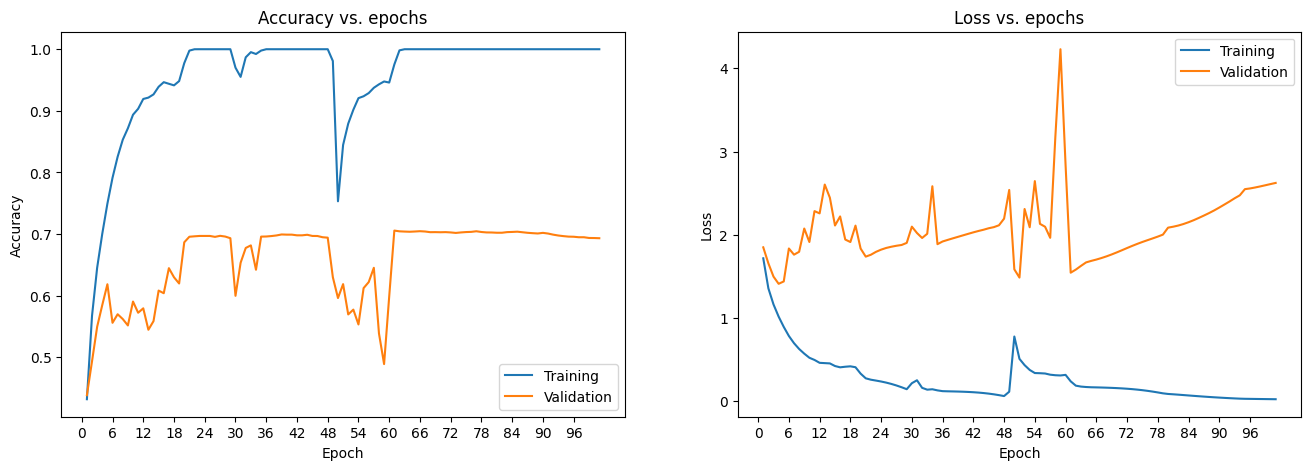

2022-08-09 10:50:22,479: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-08-09 10:50:45,732: INFO: test loss:1.5445
2022-08-09 10:50:45,733: INFO: test accuracy:0.7056
2022-08-09 10:50:45,737: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 10:50:45,739: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 10:50:45,740: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 10:50:45,741: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 10:50:45,742: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_20

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 10:50:48,247: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator


313/313 [==============================] - 1s 3ms/step


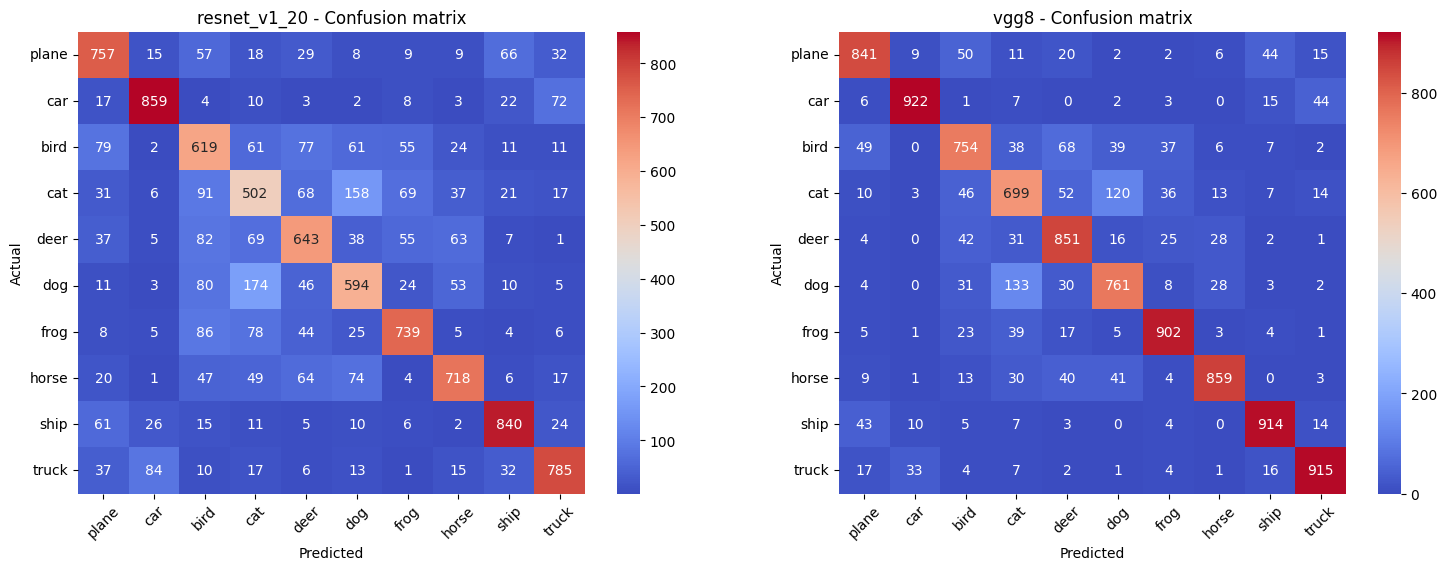

2022-08-09 10:50:54,721: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/vgg8


----------------------------------------sample analysis----------------------------------------


2022-08-09 10:50:56,368: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 10:50:56,378: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/custom1
2022-08-09 10:50:57,380: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 10:50:57,386: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/lenet1
2022-08-09 10:50:58,250: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/default.generator
2022-08-09 10:50:58,254: INFO: loading model from /tf/eipi10/xuxiangwen.gi

1/1 [==============================] - 0s 9ms/step


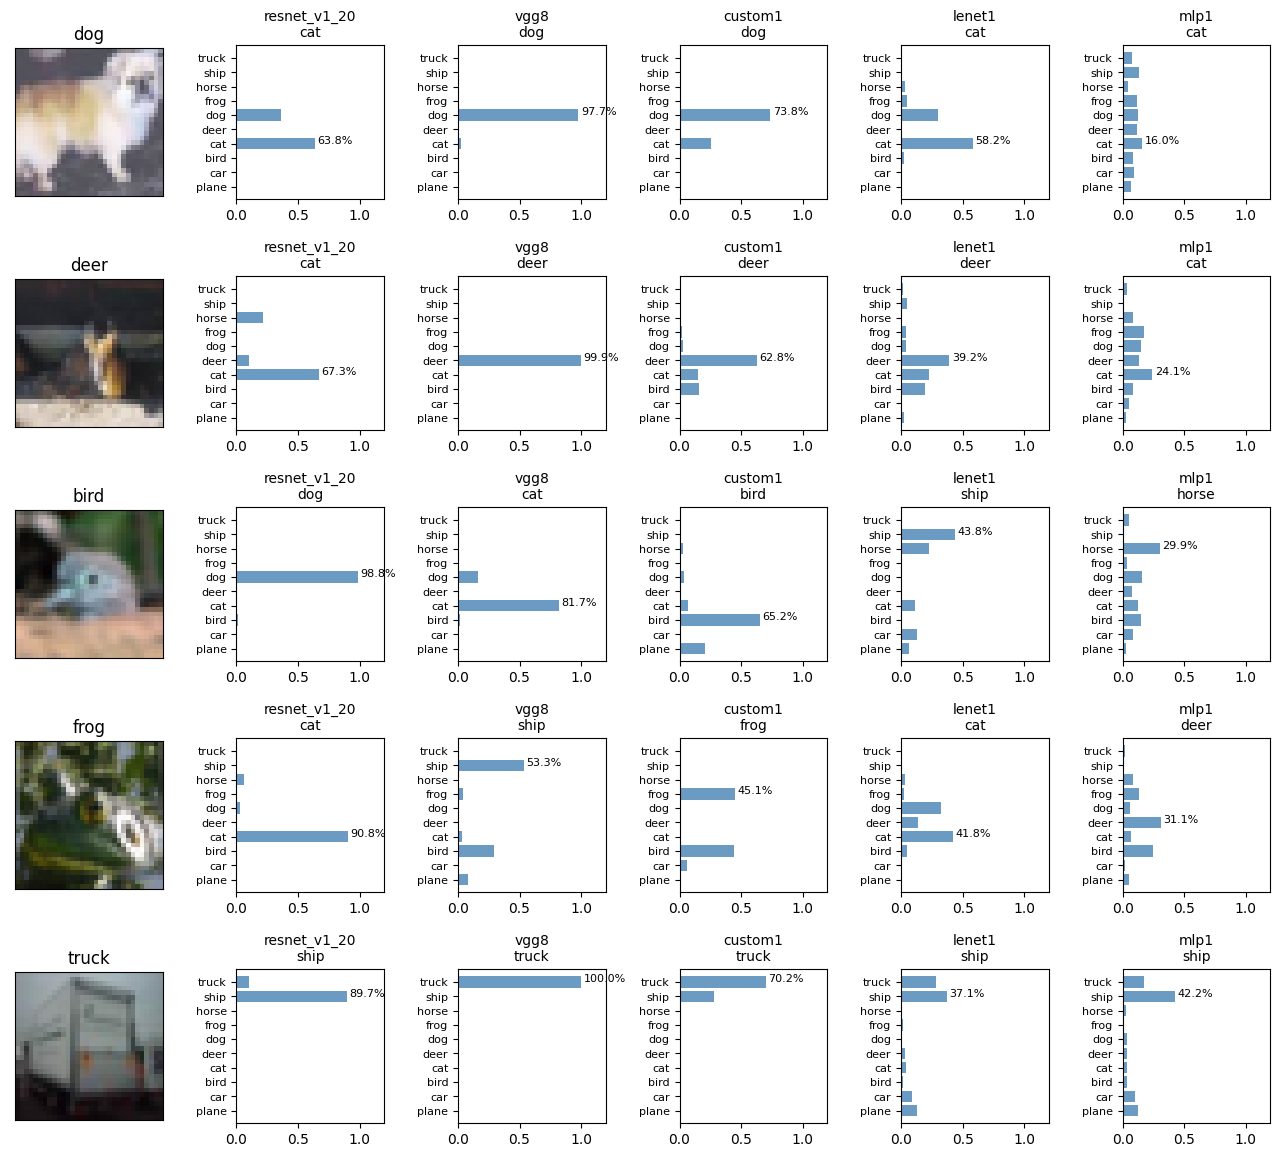

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1          vgg8  cifar10_0808_count_2000.ipynb        1672906      1399.2   
2       custom1  cifar10_0808_count_2000.ipynb          73738       744.4   
3  resnet_v1_20  cifar10_0808_count_2000.ipynb         273066      1661.7   
4        lenet1  cifar10_0808_count_2000.ipynb          83170       743.4   
5          mlp1  cifar10_0808_count_2000.ipynb         394634       222.9   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 10:22      0.0064     0.8481          0.9987         0.8418   
2  2022-08-09 09:58      0.2042     0.8459          0.9377         0.7404   
3  2022-08-09 10:50      0.2065     1.5445          0.9892         0.7056   
4  2022-08-09 09:45      0.3296     0.9833          0.8987         0.6770   
5  2022-08-09 09:32      1.5051     1.6828          0.4631         0.4016   

   train_auc  test_auc  
1     1.0000    0.9838  
2     0.9978    0.9643  
3     0.9999    0.9523  
4     0.9944    0.9474  
5     0.8671    0.8286

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [25]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-09 10:51:06,719: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-09 10:51:06,721: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2022-08-09 10:51:06,722: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 10:51:06,723: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 10:51:06,724: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 10:51:06,726: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflo

model_name                   program_name  weight_number  train_time  \
1           vgg8        cifar10_0808_p100.ipynb        1672906      2759.0   
2           vgg8        cifar10_0721_p100.ipynb        1672906      2195.2   
3           vgg8  cifar10_0808_count_5000.ipynb        1672906      1973.9   
4           vgg8  cifar10_0808_count_2000.ipynb        1672906      1399.2   
5   resnet_v1_20  cifar10_0808_count_5000.ipynb         273066      2984.0   
6   resnet_v1_20        cifar10_0721_p100.ipynb         273066      4091.3   
7        custom1        cifar10_0808_p100.ipynb          73738       849.4   
8        custom1  cifar10_0808_count_5000.ipynb          73738       836.9   
9        custom1        cifar10_0721_p100.ipynb          73738      1190.8   
10       custom1  cifar10_0808_count_2000.ipynb          73738       744.4   

         create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1   2022-08-09 10:18      0.0017     0.5896          0.9997         0.8968   
2   2021-12-02 08:49      0.0029     0.5959          0.9995         0.8921   
3   2022-08-09 07:07      0.0044     0.5588          0.9991         0.8873   
4   2022-08-09 10:22      0.0064     0.8481          0.9987         0.8418   
5   2022-08-09 07:58      0.2096     1.1902          0.9986         0.8252   
6   2021-12-02 09:58      0.1180     1.3054          0.9985         0.8197   
7   2022-08-09 09:31      0.3383     0.5942          0.8858         0.8009   
8   2022-08-09 06:34      0.3235     0.6073          0.8893         0.7981   
9   2021-12-02 08:12      0.3420     0.6094          0.8832         0.7947   
10  2022-08-09 09:58      0.2042     0.8459          0.9377         0.7404   

    train_auc  test_auc  
1      1.0000    0.9922  
2      1.0000    0.9920  
3      1.0000    0.9919  
4      1.0000    0.9838  
5      1.0000    0.9810  
6      1.0000    0.9791  
7      0.9926    0.9778  
8      0.9934    0.9776  
9      0.9929    0.9776  
10     0.9978    0.9643

In [26]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-09 10:51:06,813: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8
2022-08-09 10:51:08,434: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 10:51:08,444: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8
2022-08-09 10:51:10,227: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2022-08-09 10:51:10,237: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8
2022-08-09 10:51:12,357: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_c

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 0s 14ms/step


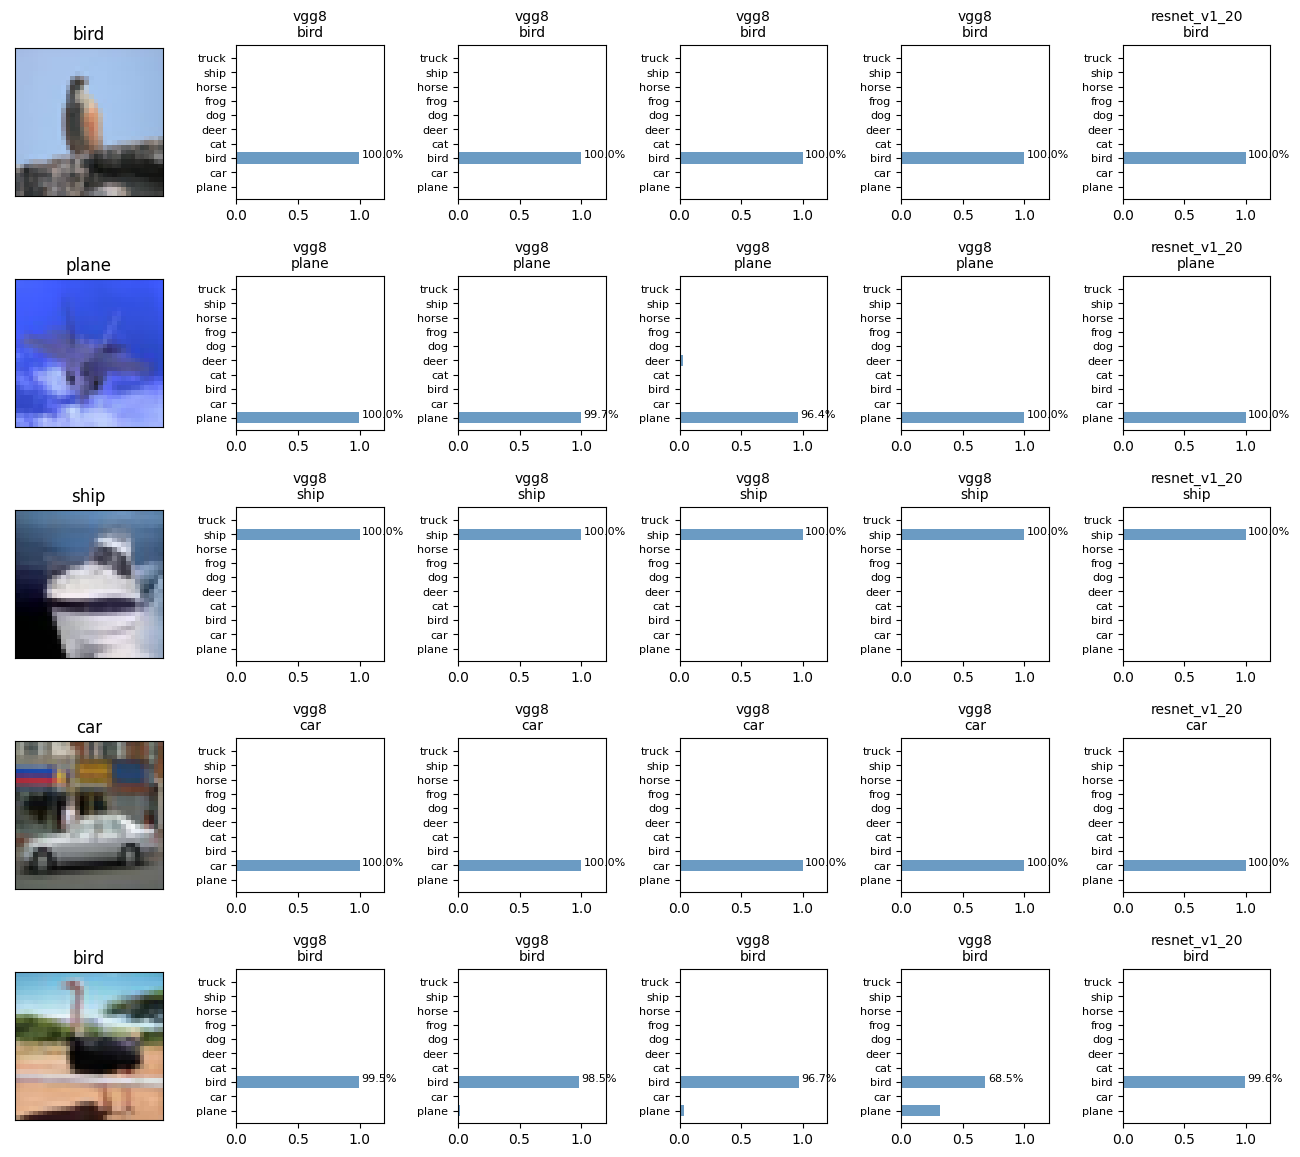

In [27]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 14ms/step


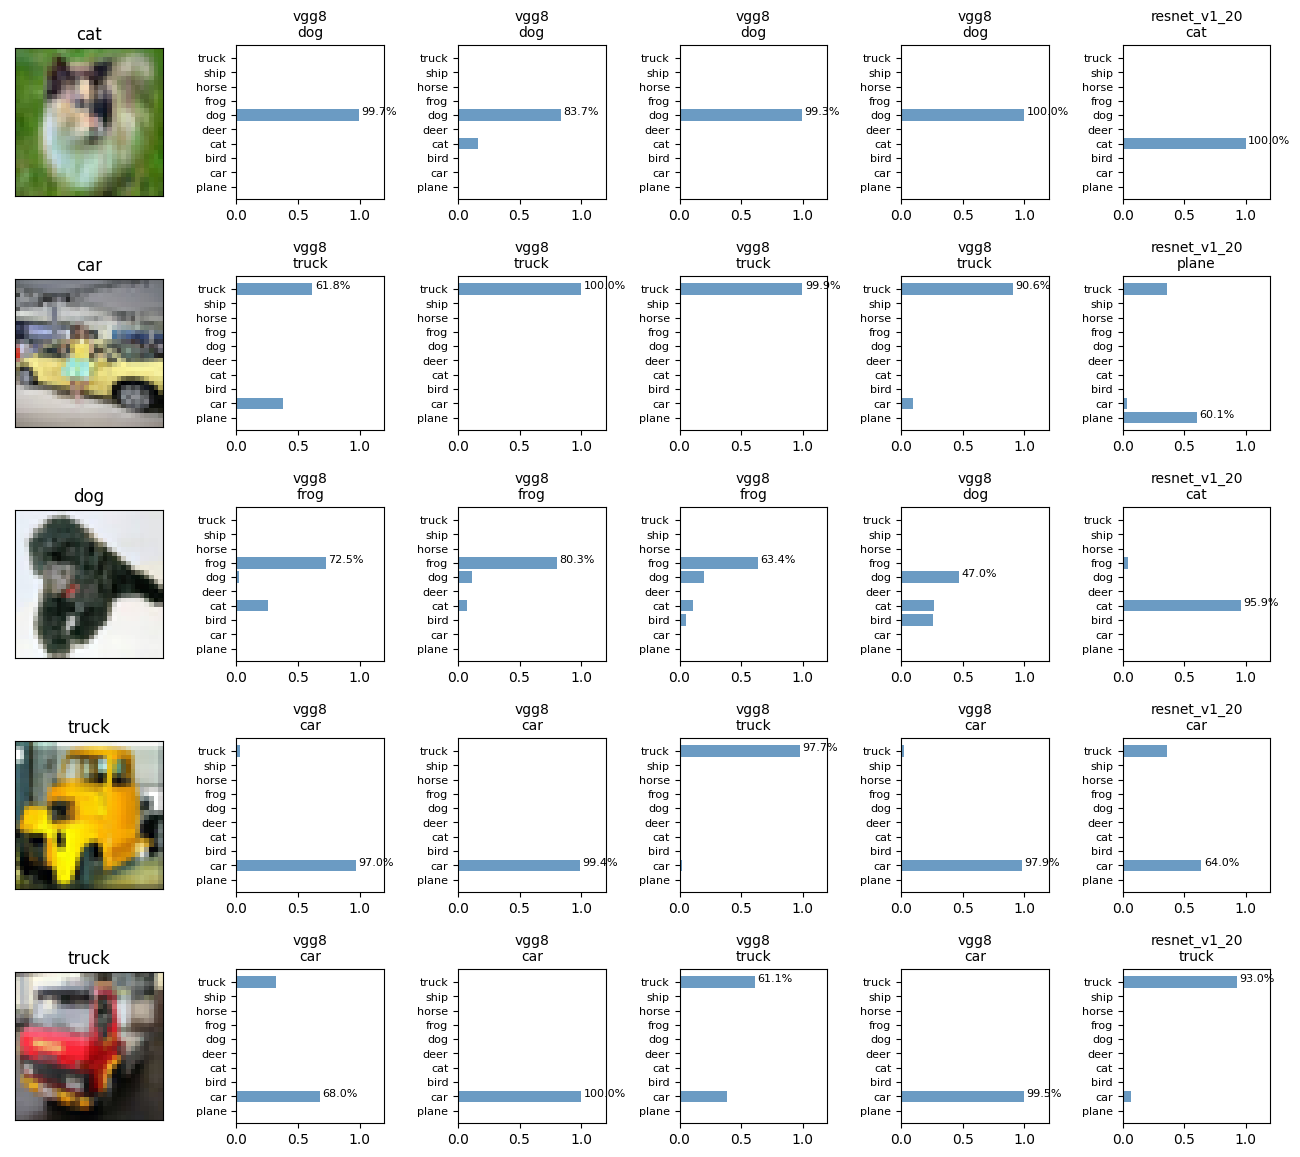

In [28]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [29]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.5896327495574951, 'accuracy': 0.8967999815940857, 'mae': 25.367116928100586}
313/313 [==============================] - 1s 4ms/step
(10000, 10)


In [30]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 1s 4ms/step


precision  recall        f1
plane   0.904245   0.916  0.910084
car     0.944334   0.950  0.947159
bird    0.872802   0.844  0.858160
cat     0.819549   0.763  0.790264
deer    0.889655   0.903  0.896278
dog     0.824832   0.857  0.840608
frog    0.897901   0.941  0.918945
horse   0.941358   0.915  0.927992
ship    0.943775   0.940  0.941884
truck   0.926950   0.939  0.932936

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9042    0.9160    0.9101      1000
         car     0.9443    0.9500    0.9472      1000
        bird     0.8728    0.8440    0.8582      1000
         cat     0.8195    0.7630    0.7903      1000
        deer     0.8897    0.9030    0.8963      1000
         dog     0.8248    0.8570    0.8406      1000
        frog     0.8979    0.9410    0.9189      1000
       horse     0.9414    0.9150    0.9280      1000
        ship     0.9438    0.9400    0.9419      1000
       truck     0.9269    0.9390    0.9329      1000

    accuracy                         0.8968     10000
   macro avg     0.8965    0.8968    0.8964     10000
weighted avg     0.8965    0.8968    0.8964     10000



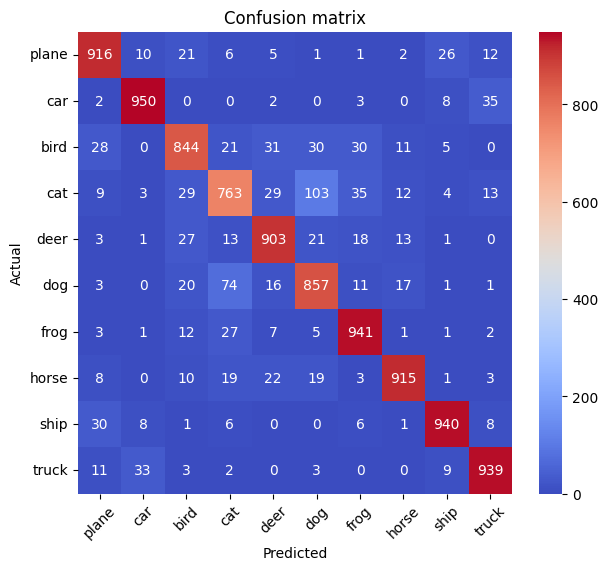

In [31]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [32]:
type(helper.datasets.train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset